In [122]:
# import packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from aero_design_functions import get_design_functions, single_point_design
from scipy.optimize import fsolve
from lacbox.io import load_pwr, load_ind, load_inds, load_ae, load_pc, load_oper, load_st, save_st
from lacbox.test import test_data_path
from myteampack import MyHTC
from pathlib import Path
from our_functions import extract_bd_master, scale_ST_data
from our_values import *

import copy
import matplotlib.ticker as ticker

plt.rcParams.update({'font.family': 'serif', 'font.size':14})


## COMPUTE REMODEL PARAMETERS <b>
modifications: <b>
- shorter blade: -1% <b>
- larger chord: +0.5% <b>
- change Cl reduction factor from 0.4 to 0.3 => new design function <b>
- max ts 90 m/s

In [123]:
# compute R_Y and V_RATED_Y

#Former class IA
V_rated_X = 11.4  # m/s
I_rated_X = 0.16
R_X = 89.17  # m

#New Class IIIB
I_rated_Y = 0.14

# Define the system of nonlinear equations
def equations(vars):
    V_rated_Y, R_Y = vars
    eq1 = V_rated_Y - (R_X / R_Y)**(2/3) * V_rated_X
    eq2 = R_Y - ((V_rated_X * (1 + 2 * I_rated_X)) / (V_rated_Y * (1 + 2 * I_rated_Y)))**(2/3) * R_X
    return [eq1, eq2]

# Initial guesses for V_rated_Y and R_Y
initial_guess = [1, 1]

# Solve the system of equations
solution = fsolve(equations, initial_guess)

# Extract the solution
V_rated_Y, R_Y = solution

print(f'type      |    R     |    V      ')
print(f'DTU 10 MW |  {R_X:.3f}  |  {V_rated_X:.3f}')
print(f'Group1    |  {R_Y:.3f}  |  {V_rated_Y:.3f}')

# modification: new blade is 1% smaller to reduce loads
R_Y = R_Y *0.99
V_rated_Y = (R_X/R_Y)**(2/3)*V_rated_X

print(f'remodel   |  {R_Y:.3f}  |  {V_rated_Y:.3f}')

print()
print('final values')
print(f"V_rated_Y: {V_rated_Y} m/s")
print(f"R_Y: {R_Y} m")
#

type      |    R     |    V      
DTU 10 MW |  89.170  |  11.400
Group1    |  92.524  |  11.123
remodel   |  91.599  |  11.198

final values
V_rated_Y: 11.197563974599802 m/s
R_Y: 91.59899634459074 m


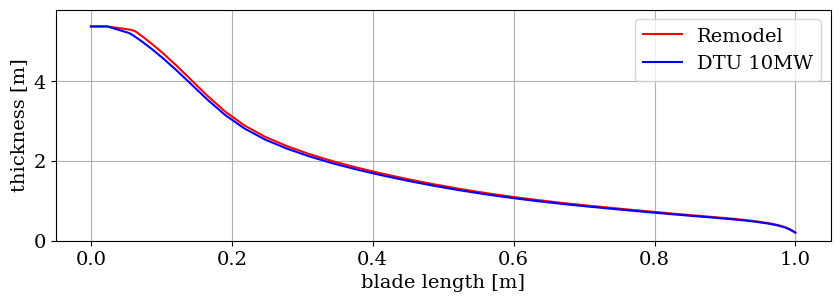

In [124]:
# new thickness

Data_ae = load_ae("dtu_10mw/data/DTU_10MW_RWT_ae.dat")

# Data from the DTU 10MW
data_ae = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }

abs_t_dtu = data_ae["chord"]*data_ae["rel_th"]/100 # dtu thickness
abs_t=data_ae["chord"]*data_ae["rel_th"]/100*R_Y/R_X # new thickness

# to force the thickness at the root and make it smoother
abs_t[0:2]=data_ae["chord"][0:2]
abs_t[2]=0.99*abs_t[2]

#plot the former blade shape and the new one
plt.figure(figsize=(10,3))
plt.plot(data_ae['curve']/max(data_ae['curve']), abs_t,     color='r', label='Remodel')
plt.plot(data_ae['curve']/max(data_ae['curve']), abs_t_dtu, color='b', label='DTU 10MW')
plt.ylim(0,5.8)
plt.xlabel('blade length [m]')
plt.ylabel('thickness [m]')
plt.grid()
plt.legend()
plt.savefig('plots/bd_thickness_blade_span.pdf', format='pdf')
plt.show()

zoom = False
if zoom:
    plt.figure(figsize=(10,3))
    plt.plot(data_ae['curve'], abs_t,     marker='o', color='r', label='Remodel')
    plt.plot(data_ae['curve'], abs_t_dtu, marker='o', color='b', label='DTU 10MW')
    plt.xlabel('blade length [m]')
    plt.ylabel('thickness [m]')
    plt.grid()
    plt.legend()
    plt.xlim(0,10)
    plt.ylim(4, 6)
    plt.show()


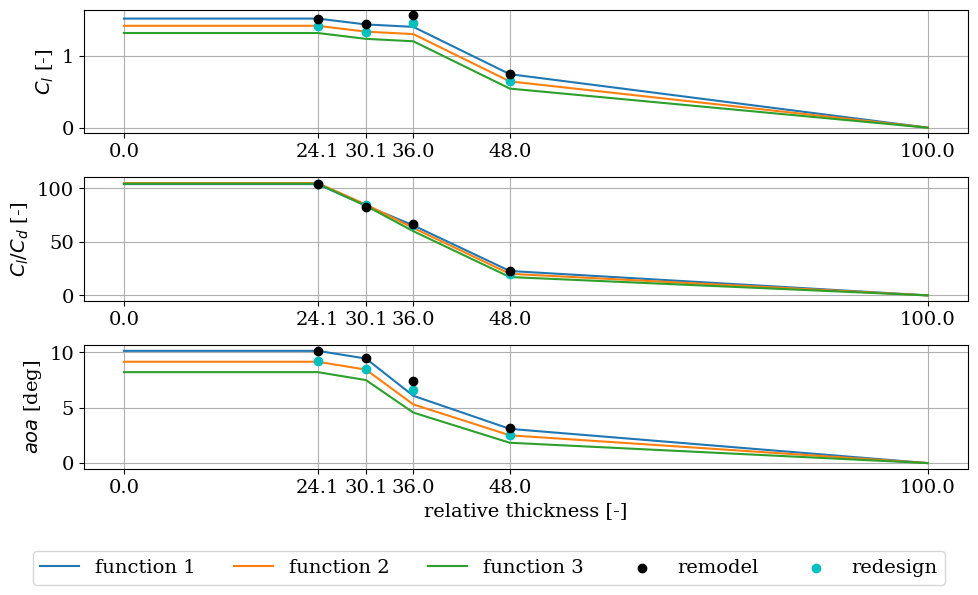

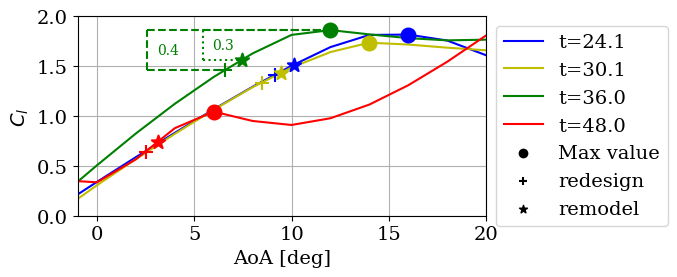

In [125]:
# design function

# Define a cl plot for the 10MW using the pc.dat
Data_cl = load_pc("dtu_10mw/data/DTU_10MW_RWT_pc.dat") # return a list per blade
n = len(Data_cl)-2 # exclude airfoils of 100% and 60% relative thickness
des_param = np.zeros((4,n)) # relative thickness, cl design, cd design, AoA design
arg_0 = [63,63,63,58] # indices of the AoAs before stall

for k in range(n):
    cl_max = np.amax(Data_cl[k]["cl"][50:arg_0[k]])  # Maximum lift coefficient within the range
    cl_des = cl_max - 0.3

    # Finding corresponding AoA
    arg_max = np.where(Data_cl[k]["cl"] == cl_max)
    aoa_max = Data_cl[k]["aoa_deg"][arg_max]
    
    # Interpolating to find AoA and Cd of Cl design
    aoa_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["aoa_deg"][50:arg_0[k]])
    cd_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["cd"][50:arg_0[k]])
    des_param[:, k] = [Data_cl[k]["tc"], cl_des, cd_des, aoa_des]

_, _, _, tc_vals, cl_vals1, cd_vals1, aoa_vals1 = get_design_functions(1)
_, _, _, tc_vals, cl_vals2, cd_vals2, aoa_vals2 = get_design_functions(2)
_, _, _, tc_vals, cl_vals3, cd_vals3, aoa_vals3 = get_design_functions(3)



# redesign values
des_param_our = np.zeros((4,n))

for k in range(n):
    cl_max = np.amax(Data_cl[k]["cl"][50:arg_0[k]])  # Maximum lift coefficient within the range
    cl_des = cl_max - 0.4

    # Finding corresponding AoA
    arg_max = np.where(Data_cl[k]["cl"] == cl_max)
    aoa_max = Data_cl[k]["aoa_deg"][arg_max]
    
    # Interpolating to find AoA and Cd of Cl design
    aoa_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["aoa_deg"][50:arg_0[k]])
    cd_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["cd"][50:arg_0[k]])
    des_param_our[:, k] = [Data_cl[k]["tc"], cl_des, cd_des, aoa_des]



fig1, axs1 = plt.subplots(3, 1, num=1, figsize=(10,6), clear=True) 
# lift
axs1[0].plot(tc_vals, cl_vals1, label='function 1')
axs1[0].plot(tc_vals, cl_vals2, label='function 2')
axs1[0].plot(tc_vals, cl_vals3, label='function 3')
axs1[0].scatter(des_param[0], des_param[1], label='remodel', color='k',zorder=3)
axs1[0].scatter(des_param_our[0], des_param_our[1], label='redesign', color='c', zorder=2)
axs1[0].set_ylabel('$C_l$ [-]')
#axs1[0].legend()
axs1[0].grid()

# lift / drag
axs1[1].plot(tc_vals, cl_vals1/cd_vals1)
axs1[1].plot(tc_vals, cl_vals2/cd_vals2)
axs1[1].plot(tc_vals, cl_vals3/cd_vals3)
axs1[1].scatter(des_param[0], des_param[1]/des_param[2], color='k', zorder=3)
axs1[1].scatter(des_param_our[0], des_param_our[1]/des_param_our[2], color='c', zorder=2)
axs1[1].set_ylabel('$C_l/C_d$ [-]')
axs1[1].grid()

# AoA
axs1[2].plot(tc_vals, aoa_vals1)
axs1[2].plot(tc_vals, aoa_vals2)
axs1[2].plot(tc_vals, aoa_vals3)
axs1[2].scatter(des_param[0], des_param[3], color='k', zorder=3)
axs1[2].scatter(des_param_our[0], des_param_our[3], color='c', zorder=2)
axs1[2].set_ylabel('$aoa$ [deg]')
axs1[2].set_xlabel('relative thickness [-]')
axs1[2].grid()

axs1[2].set_xticks(tc_vals)  # for the bottom plot
plt.setp(axs1, xticks=tc_vals)  # apply xticks for all subplots
fig1.tight_layout()

plt.subplots_adjust(bottom=0.2)  # Add more space at the bottom if needed
fig1.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.01))

plt.savefig('plots/bd_computed_vs_design funct.pdf', format='pdf')
plt.show()



# Cl vs AoA curves
color_list = ['b', 'y', 'g', 'r']
plt.figure(figsize=(7,3))

for k in range(n):
    plt.plot(Data_cl[k]["aoa_deg"], Data_cl[k]["cl"], label=f"t={des_param[0,k]}", color=color_list[k])
    
    # redesign
    SF = 0.4

    cl_max = np.amax(Data_cl[k]["cl"][50:arg_0[k]])  # Maximum lift coefficient within the range
    cl_des = cl_max - SF

    arg_max = np.where(Data_cl[k]["cl"] == cl_max)
    aoa_max = Data_cl[k]["aoa_deg"][arg_max]
    
    # Interpolating to find AoA and Cd of Cl design
    aoa_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["aoa_deg"][50:arg_0[k]])
    cd_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["cd"][50:arg_0[k]])
    des_param_our[:, k] = [Data_cl[k]["tc"], cl_des, cd_des, aoa_des]
    plt.scatter(aoa_des, cl_des, marker="+", color=color_list[k], s=100, linewidths=1.5, zorder=3)

    if k == 2:
        offset = 4
        plt.plot([aoa_des-offset, aoa_des-offset], [cl_des, cl_max], color=color_list[k], linestyle='--')
        plt.plot([aoa_des-offset, aoa_des], [cl_des, cl_des], color=color_list[k]       , linestyle='--')
        plt.plot([aoa_des-offset, aoa_max[0]], [cl_max, cl_max], color=color_list[k]    , linestyle='--')

        plt.text(aoa_des-offset+0.5, (cl_max + cl_des) / 2, f'{SF}', 
            verticalalignment='center', horizontalalignment='left', 
            color=color_list[k], fontsize=10)
    
    # remodel
    SF = 0.3

    cl_max = np.amax(Data_cl[k]["cl"][50:arg_0[k]])  # Maximum lift coefficient within the range
    cl_des = cl_max - SF

    arg_max = np.where(Data_cl[k]["cl"] == cl_max)
    aoa_max = Data_cl[k]["aoa_deg"][arg_max]
    
    # Interpolating to find AoA and Cd of Cl design
    aoa_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["aoa_deg"][50:arg_0[k]])
    cd_des = np.interp(cl_des, Data_cl[k]["cl"][50:arg_0[k]], Data_cl[k]["cd"][50:arg_0[k]])
    des_param_our[:, k] = [Data_cl[k]["tc"], cl_des, cd_des, aoa_des]
    plt.scatter(aoa_des, cl_des, marker="*", color=color_list[k], s=100, linewidths=1.5, zorder=3)

    plt.scatter(aoa_max, cl_max, marker="o", color=color_list[k], s=100, linewidths=1.5, zorder=3)

    if k == 2:
        offset = 2
        plt.plot([aoa_des-offset, aoa_des-offset], [cl_des, cl_max], color=color_list[k], linestyle=':')
        plt.plot([aoa_des-offset, aoa_des], [cl_des, cl_des], color=color_list[k]       , linestyle=':')
        plt.plot([aoa_des-offset, aoa_max[0]], [cl_max, cl_max], color=color_list[k]    , linestyle=':')

        plt.text(aoa_des-offset+0.5, (cl_max + cl_des) / 2, f'{SF}', 
            verticalalignment='center', horizontalalignment='left', 
            color=color_list[k], fontsize=10)

plt.scatter([], [], marker="o", color="k", label="Max value")
plt.scatter([], [], marker="+", color="k", label="redesign")
plt.scatter([], [], marker="*", color="k", label="remodel")

plt.xlim(-1, 20)
plt.ylim(0, 2)
plt.xlabel('AoA [deg]')
plt.ylabel('$C_l$')
plt.grid()

# Adjust layout to make space for the legend
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend
plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(1.001, 1))  # Move legend to the right

# Use tight_layout() to ensure everything fits well
plt.tight_layout()

# Save the figure with extra padding on the right
plt.savefig('plots/bd_cl_curve.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)

plt.show()

In [126]:
# evaluate optimal blade hape with single_point_design function
# change in max chord

r_hub = 2.8  # Hub radius [m]
r = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]
chord_root = 5.38  # Chord size at the root [m]
chord_max_redesign = 6.3 
chord_max = chord_max_redesign*1.01 # max chord increased by 1% to increase power production
print('new max chord:', chord_max)

t = abs_t # Absolute thickness [m]
B = 3  # Number of blades [#]
design_number = 1
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(design_number)

TSR = np.linspace(6,12,20)
CP_list = []
for tsr in TSR:
    # %% Solving for the a single design
    chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
        r, t, tsr, R_Y, cl_des, cd_des, aoa_des, chord_root, chord_max, B)
    CP_list.append(CP)

CP_max=np.amax(CP_list)
TSR_max=TSR[np.argmax(CP_list)]


print('best blade:')
print('CP =', CP_max)
print('TSR =', TSR_max)



new max chord: 6.3629999999999995
best blade:
CP = 0.44517652242177447
TSR = 6.947368421052632


## CREATE NEW MASTER FILE
evaluate single_point_design using optimal input quantities

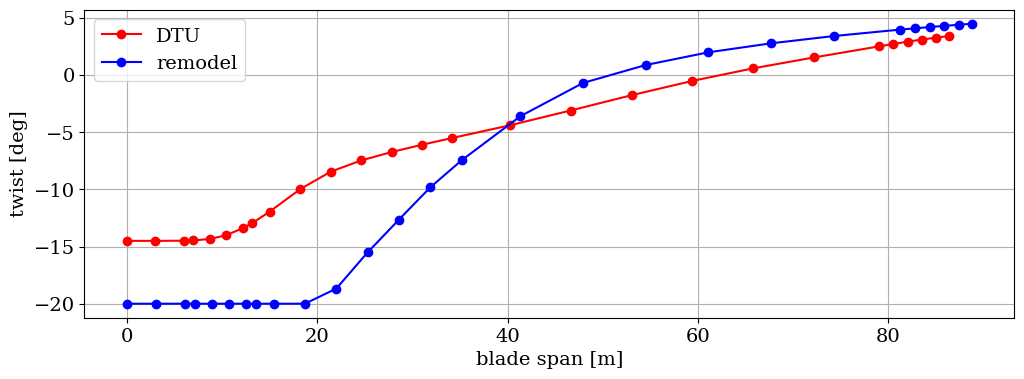

Data saved to remodel/_master/modify.txt
Data saved to remodel/data/remodel_ae.dat


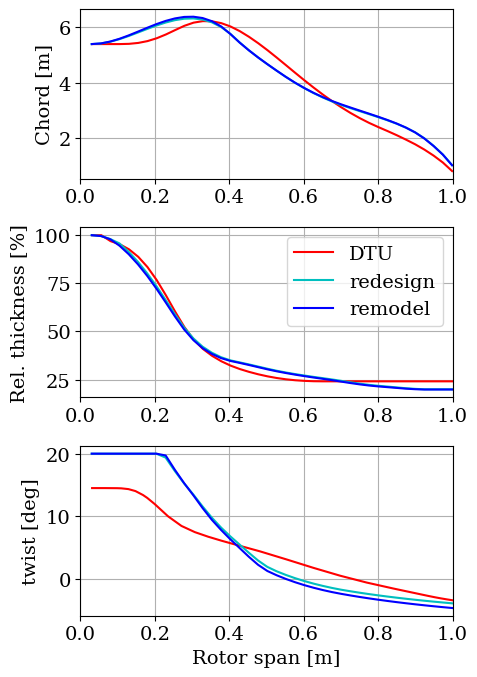

[-20.         -20.         -20.         -20.         -20.
 -20.         -20.         -20.         -20.         -19.99910688
 -18.67244274 -15.50140238 -12.63423225  -9.81397652  -7.44843954
  -3.59119436  -0.68037705   0.88663435   1.99909252   2.78628084
   3.4217265    3.98746698   4.10024818   4.20858676   4.31262063
   4.41387652   4.50099076]
[-14.5      -14.5      -14.4851   -14.461    -14.3388   -14.0201
 -13.3904   -12.9371   -11.9445    -9.98243   -8.45147   -7.46417
  -6.72916   -6.08842   -5.49322   -4.39222   -3.09315   -1.75629
  -0.50065    0.601964   1.5556     2.51935    2.7295     2.93201
   3.11874    3.28847    3.42796 ]


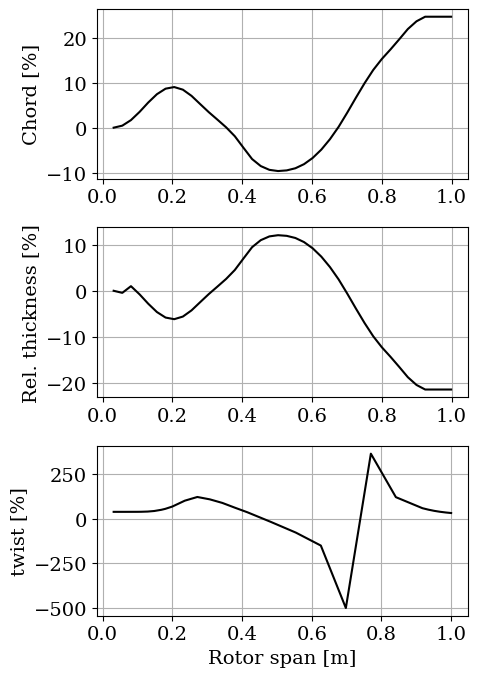

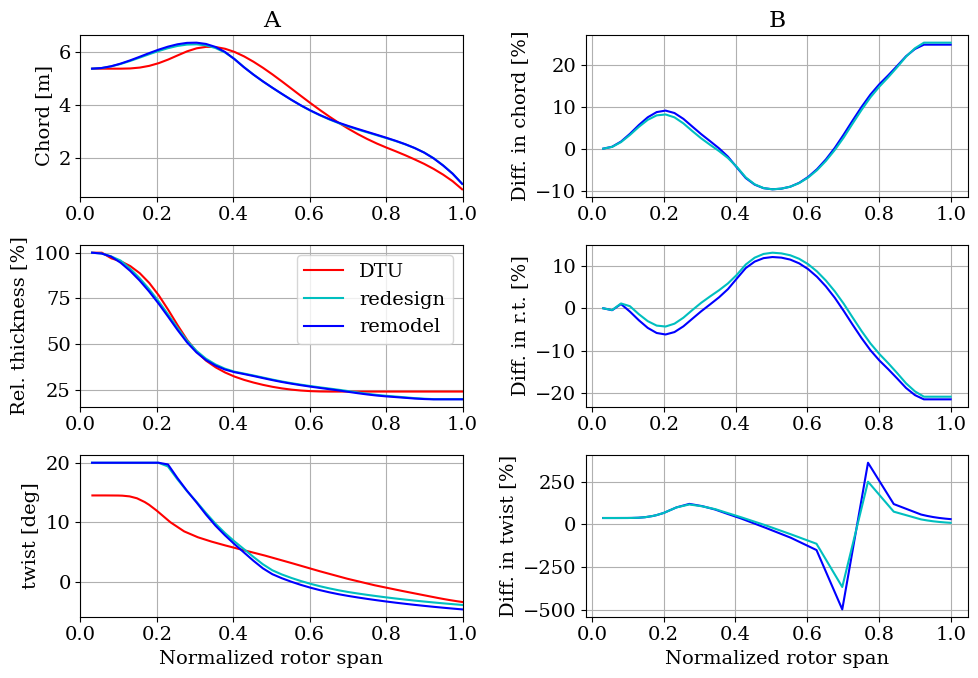

In [127]:
# new z and twist

r_hub = 2.8  # Hub radius [m]
r = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]
scale = (R_Y - r_hub)/(R_X - r_hub)
#tsr = 7.2631578947368425
tsr = 6.947368421052632

cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(design_number)
chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R_Y, cl_des, cd_des, aoa_des, chord_root, chord_max, B)

data_master_our = extract_bd_master("our_design/_master/Group1_redesign.htc")

file_path = "dtu_10mw/_master/dtu_10mw.htc"
data_master = extract_bd_master(file_path)

new_z =data_master['z']*scale
new_twist = -np.interp(new_z, r, twist)             # minus sign to be consistent with htc

twist_interp = True
if twist_interp == True:
    plt.figure(figsize=(12,4))
    plt.plot(data_master['z'], data_master['twist'], marker='o', label='DTU', color='r')
    plt.plot(new_z, new_twist, marker='o',  label='remodel', color='b')
    plt.xlabel('blade span [m]')
    plt.ylabel('twist [deg]')
    plt.grid()
    plt.legend()
    plt.show()


# write down changes

# blade definition in master file
output_file = 'remodel/_master/modify.txt'

# Open the file for writing
with open(output_file, 'w') as file:
    file.write(f'# change new_htc_structure_blade1 with this\n\n')
    for i in range(len(data_master['number'])):
        # Construct the formatted string
        line = f"sec {data_master['number'][i]} {data_master['x'][i]:.5E} {data_master['y'][i]:.5E} {new_z[i]:.5E} {new_twist[i]:.5E} ;\n"
        # Write the line to the file
        file.write(line)

print(f"Data saved to {output_file}")


# aerodynamic file
new_curve = r - r_hub
tc[2] = tc[2]*1.01

output_file = 'remodel/data/remodel_ae.dat'

# Open the file for writing
with open(output_file, 'w') as file:
    file.write(f'1\n')
    file.write(f'1  40\n')
    for i in range(40):
        # Construct the formatted string
        line = f"{new_curve[i]:.5E} {chord[i]:.5E} {tc[i]:.5E} 1  ;\n"
        # Write the line to the file
        file.write(line)

print(f"Data saved to {output_file}")



# display aerodynamic data
Data_ae = load_ae("dtu_10mw/data/DTU_10MW_RWT_ae.dat")
ae_DTU = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }
r_DTU = np.linspace(r_hub, R_X - 0.1, 40)

Data_ae = load_ae("our_design/data/DTU_10MW_RWT_ae.dat")
ae_our = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }

r_our = np.linspace(r_hub, R_Y_old - 0.1, 40)
twist_our = [20.        , 20.        , 20.        , 20.        , 20.        , 20.        ,
             20.        , 20.        , 19.37724617, 17.22497201, 15.24863829, 13.46830149,
             11.57024301,  9.7753592 ,  8.19674475,  6.78824525,  5.48401412,  4.17750717,
             2.93210526 ,  1.91483855,  1.21180261,  0.62783694,  0.10892417, -0.35287007,
             -0.76408582, -1.12993299, -1.45656244, -1.74364384, -1.99196778, -2.22283601,
             -2.43943218, -2.64302576, -2.83474162, -3.01557979, -3.18643217, -3.34809659,
             -3.50128882, -3.64665274, -3.78476909, -3.91616297]


fig2, axs2 = plt.subplots(3, 1, num=1, figsize=(5,7), clear=True)
# Chord
axs2[0].plot(r_DTU/R_X,     ae_DTU['chord'], color='r', label="DTU")
axs2[0].plot(r_our/R_Y_old, ae_our['chord'], color='c', label="redesign")
axs2[0].plot(r/R_Y, chord, color='b',                   label="remodel")
axs2[0].set_ylabel("Chord [m]")
axs2[0].set_xlim(0, 1)
axs2[0].grid(True)

# t/c
axs2[1].plot(r_DTU/R_X,     ae_DTU['rel_th'], color='r',  label='DTU')
axs2[1].plot(r_our/R_Y_old, ae_our['rel_th'], color='c',  label='redesign')
axs2[1].plot(r/R_Y, tc, color='b', label='remodel')
axs2[1].set_ylabel("Rel. thickness [%]")
axs2[1].set_xlim(0, 1)
axs2[1].grid(True)
axs2[1].legend()

# Twist
axs2[2].plot((data_master['z']+R_HUB)/R_X, - data_master['twist'], color='r')
axs2[2].plot(r_our/R_Y_old, twist_our, color='c')
axs2[2].plot(r/R_Y, twist, color='b')
axs2[2].set_ylabel("twist [deg]")
axs2[2].set_xlim(0, 1)
axs2[2].grid(True)
axs2[2].set_xlabel("Rotor span [m]")

fig2.tight_layout()
fig2.savefig('plots/bd_chord_rt_twist.pdf', format='pdf')
plt.show()



percentage = True
if percentage:

    print(new_twist)
    print(data_master['twist'])



    fig3, axs3 = plt.subplots(3, 1, num=1, figsize=(5,7), clear=True)
    
    # Chord
    axs3[0].plot(r_DTU/R_X, (chord - ae_DTU['chord'])/ae_DTU['chord']*100, color='k')
    axs3[0].set_ylabel("Chord [%]")
    axs3[0].grid(True)

    # t/c
    axs3[1].plot(r_DTU/R_X,   (tc - ae_DTU['rel_th'])/tc*100, color='k')
    axs3[1].set_ylabel("Rel. thickness [%]")
    axs3[1].grid(True)

    # Twist
    x = (data_master['z']+R_HUB)/R_X
    y1 = new_twist           
    y2 = data_master['twist']
    axs3[2].plot(x, (y1 - y2)/y2 * 100, color='k')
    axs3[2].set_ylabel("twist [%]")
    axs3[2].grid(True)
    axs3[2].set_xlabel("Rotor span [m]")
    fig3.tight_layout()
    fig3.savefig('plots/bd_chord_rt_twist_percentage.pdf', format='pdf')
    plt.show()


zoom = False
if zoom:
    fig3, axs3 = plt.subplots(3, 1, num=1, figsize=(10,7), clear=True)
    # Chord
    axs3[0].plot(r_DTU/R_X,     ae_DTU['chord'], color='r')
    axs3[0].plot(r_our/R_Y_old, ae_our['chord'], color='c')
    axs3[0].plot(r/R_Y, chord, color='b')
    axs3[0].set_ylabel("Chord [m]")
    axs3[0].set_xlim(0.02, 0.2)
    axs3[0].set_ylim(5, 6)
    axs3[0].grid(True)

    # Twist
    axs3[1].plot((data_master['z']+R_HUB)/R_X, - data_master['twist'], color='r',label="DTU")
    axs3[1].plot(r_our/R_Y_old, twist_our, color='c', label="redesign")
    axs3[1].plot(r/R_Y, twist, color='b',label="remodel")
    axs3[1].set_ylabel("twist [deg]")
    axs3[1].set_xlim(0.02, 0.2)
    axs3[1].set_ylim(10, 21)
    axs3[1].grid(True)
    axs3[1].legend()

    # t/c
    axs3[2].plot(r_DTU/R_X,     ae_DTU['rel_th'], color='r', marker='o')
    axs3[2].plot(r_our/R_Y_old, ae_our['rel_th'], color='c', marker='o')
    axs3[2].plot(r/R_Y, tc, color='b', marker='o')
    axs3[2].set_ylabel("Rel. thickness [%]")
    axs3[2].set_xlim(0.02, 0.2)
    axs3[2].set_ylim(90, 101)
    axs3[2].grid(True)
    axs3[2].set_xlabel("Rotor span [m]")

    #fig3.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
    fig3.tight_layout()
    #fig2.savefig('plots/bd_CP_vs_TSR.pdf', format='pdf')
    #plt.show()




fig2, axs2 = plt.subplots(3, 2, num=1, figsize=(10,7), clear=True)
# Chord
axs2[0,0].plot(r_DTU/R_X,     ae_DTU['chord'], color='r', label="DTU")
axs2[0,0].plot(r_our/R_Y_old, ae_our['chord'], color='c', label="redesign")
axs2[0,0].plot(r/R_Y, chord, color='b',                   label="remodel")
axs2[0,0].set_ylabel("Chord [m]")
axs2[0,0].set_xlim(0, 1)
axs2[0,0].grid(True)
axs2[0,0].set_title('A')

# t/c
axs2[1,0].plot(r_DTU/R_X,     ae_DTU['rel_th'], color='r',  label='DTU')
axs2[1,0].plot(r_our/R_Y_old, ae_our['rel_th'], color='c',  label='redesign')
axs2[1,0].plot(r/R_Y, tc, color='b', label='remodel')
axs2[1,0].set_ylabel("Rel. thickness [%]")
axs2[1,0].set_xlim(0, 1)
axs2[1,0].grid(True)
axs2[1,0].legend()

# Twist
axs2[2,0].plot((data_master['z']+R_HUB)/R_X, - data_master['twist'], color='r')
axs2[2,0].plot(r_our/R_Y_old, twist_our, color='c')
axs2[2,0].plot(r/R_Y, twist, color='b')
axs2[2,0].set_ylabel("twist [deg]")
axs2[2,0].set_xlim(0, 1)
axs2[2,0].grid(True)
axs2[2,0].set_xlabel("Normalized rotor span")

# percentage
# Chord
axs2[0,1].plot(r_DTU/R_X, (chord - ae_DTU['chord'])/ae_DTU['chord']*100, color='b')
axs2[0,1].plot(r_DTU/R_X, (ae_our['chord'] - ae_DTU['chord'])/ae_DTU['chord']*100, color='c')
axs2[0,1].grid(True)
axs2[0,1].set_ylabel("Diff. in chord [%]")
axs2[0,1].set_title('B')

# t/c
axs2[1,1].plot(r_DTU/R_X,   (tc - ae_DTU['rel_th'])/tc*100, color='b')
axs2[1,1].plot(r_DTU/R_X,   (ae_our['rel_th'] - ae_DTU['rel_th'])/tc*100, color='c')
axs2[1,1].grid(True)
axs2[1,1].set_ylabel("Diff. in r.t. [%]")

# Twist
x = (data_master['z']+R_HUB)/R_X
y1 = new_twist           
y2 = data_master['twist']
y3 = data_master_our['twist']
perc_rem = (y1 - y2)/y2 * 100
perc_our = (y3 - y2)/y2 * 100



lim = 1
x_i = np.argmax(y2 > -lim)
x_f = np.argmin(y2 < lim)

#axs2[2,1].plot(x[0:x_i], perc_rem[0:x_i], color='b')
#axs2[2,1].plot(x[0:x_i], perc_our[0:x_i], color='c')
#axs2[2,1].plot(x[x_f:-1], perc_rem[x_f:-1], color='b')
#axs2[2,1].plot(x[x_f:-1], perc_our[x_f:-1], color='c')
axs2[2,1].plot(x, perc_rem, color='b')
axs2[2,1].plot(x, perc_our, color='c')
axs2[2,1].grid(True)
axs2[2,1].set_ylabel("Diff. in twist [%]")
axs2[2,1].set_xlabel("Normalized rotor span")
#axs2[2,1].set_yscale("log") 

fig2.tight_layout()
fig2.savefig('plots/bd_chord_rt_twist_all.pdf', format='pdf')
plt.show()



In [128]:
x = (data_master['z']+R_HUB)/R_X
y1 = new_twist           
y2 = data_master['twist']
y3 = data_master_our['twist']

lim = 1
x_i = np.argmax(y2 > -lim)
x_f = np.argmin(y2 < lim)


print(x_i)
print(x_f)

18
20


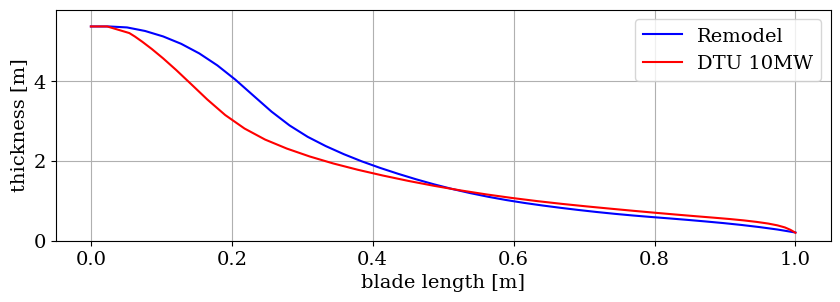

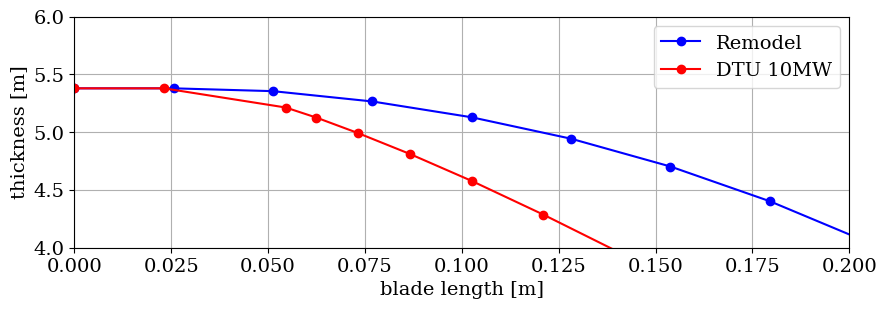

In [129]:
# check if new thickness looks good

Data_ae = load_ae("dtu_10mw/data/DTU_10MW_RWT_ae.dat")
# Data from the DTU 10MW
data_ae = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }

abs_t_dtu = data_ae["chord"]*data_ae["rel_th"]/100 # dtu thickness


Data_ae = load_ae("remodel/data/remodel_ae.dat")
# Data from the DTU 10MW
data_ae_rem = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]
    }
abs_t_rem = data_ae_rem["chord"]*data_ae_rem["rel_th"]/100 # dtu thickness


#plot the former blade shape and the new one
plt.figure(figsize=(10,3))
plt.plot(data_ae_rem['curve']/max(data_ae_rem['curve']), abs_t_rem, color='b', label='Remodel')
plt.plot(data_ae['curve']/max(data_ae['curve']), abs_t_dtu, color='r', label='DTU 10MW')
plt.ylim(0,5.8)
plt.xlabel('blade length [m]')
plt.ylabel('thickness [m]')
plt.grid()
plt.legend()
#plt.savefig('plots/bd_thickness_blade_span.pdf', format='pdf')
plt.show()


zoom = True
if zoom:
    plt.figure(figsize=(10,3))
    plt.plot(data_ae_rem['curve']/max(data_ae_rem['curve']), abs_t_rem, marker='o', color='b', label='Remodel')
    plt.plot(data_ae['curve']/max(data_ae['curve']), abs_t_dtu, marker='o', color='r', label='DTU 10MW')
    plt.xlabel('blade length [m]')
    plt.ylabel('thickness [m]')
    plt.grid()
    plt.legend()
    plt.xlim(0,0.2)
    plt.ylim(4, 6)
    plt.show()


In [130]:
# multitsr input file

# remodel
TSR_range = np.arange(5.5,10.5,0.2)
V_rated_Y_range = np.arange(V_rated_Y, V_rated_Y + len(TSR_range) * 0.001 - 0.001, 0.001)
omega_range = TSR_range * V_rated_Y_range / R_Y * 60 / (2*np.pi)

output_file = 'remodel/data/remodel_multitsr.opt'
# Open the file for writing
with open(output_file, 'w') as file:
    file.write(f'{int(len(TSR_range))} wind speed [m/s]      pitch [deg]     rot. speed [rpm]      aero power [kw]     aero thrust [kn]\n')
    for i in range(len(TSR_range)):
        # Construct the formatted string
        line = f"          {V_rated_Y_range[i]:6.6f}          0.000000          {omega_range[i]:6.6f}          500.000000          1000.000000\n"
        # Write the line to the file
        file.write(line)

print(f"Data saved to {output_file}")


# for DTU 10 MW
V_rated_X_range = np.arange(V_rated_X, V_rated_X + len(TSR_range) * 0.001 - 0.001, 0.001)
omega_range_X = TSR_range * V_rated_X_range/ R_X * 60 / (2*np.pi)
output_file = 'dtu_10mw/data/dtu_10mw_multitsr.opt'

# Open the file for writing
with open(output_file, 'w') as file:
    file.write(f'{int(len(TSR_range))} wind speed [m/s]      pitch [deg]     rot. speed [rpm]      aero power [kw]     aero thrust [kn]\n')
    for i in range(len(TSR_range)):
        # Construct the formatted string
        line = f"          {V_rated_Y_range[i]:6.6f}          0.000000          {omega_range[i]:6.6f}          500.000000          1000.000000\n"
        # Write the line to the file
        file.write(line)

print(f"Data saved to {output_file}")



Data saved to remodel/data/remodel_multitsr.opt
Data saved to dtu_10mw/data/dtu_10mw_multitsr.opt


## RUN SIMULATIONS

## POST PROCESS

DTU :            max CP = 0.483, TSR = 8.300, omega_rated = 9.600
redesign :       max CP = 0.457, TSR = 7.500, omega_rated = 8.337
remodel HAWC2 :  max CP = 0.463, TSR = 7.500, omega_rated = 8.755
anal :           max CP = 0.445 at TSR = 7.100
remodel chosen : max CP = 0.458, TSR = 8.037, omega_rated = 9.383

OMEGA_MAX: 9.382599449704426
TSR_OPT: 8.03746245202556


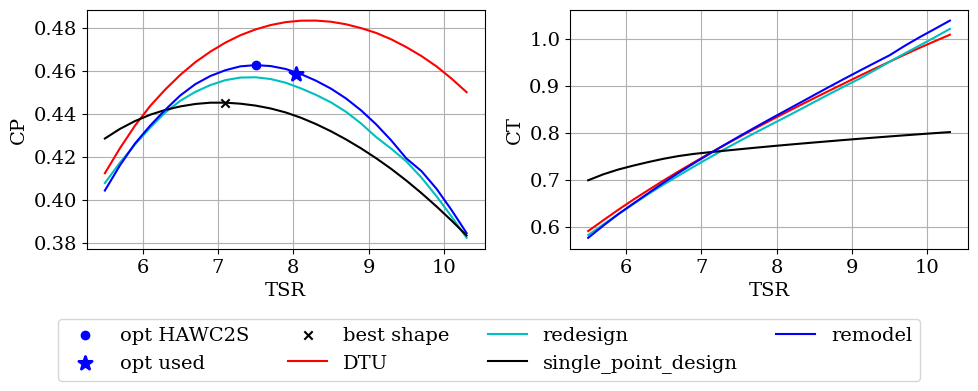

In [131]:
# Side-by-side plots of the power and thrust coefficients calculated with HAWC2S at design pitch versus TSR

pwr_data = load_pwr("remodel/res_hawc2s/remodel_hawc2s_multitsr.pwr")
pwr_data_DTU_10_MW = load_pwr("dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_multitsr.pwr")
pwr_data_redesign = load_pwr("our_design/res_hawc2s/Group1_redesign_hawc2s_multiwsp.pwr")

CP_list = []
CT_list = []
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(design_number)

for tsr in TSR_range:
    # %% Solving for the a single design
    chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
        r, t, tsr, R_Y, cl_des, cd_des, aoa_des, chord_root, chord_max, B)
    CP_list.append(CP)
    CT_list.append(CT)

CP_array = np.array(CP_list)
CT_array = np.array(CT_list)


# find max
CP_max_DTU = np.amax(pwr_data_DTU_10_MW["Cp"])
TSR_max_DTU = TSR_range[np.argmax(pwr_data_DTU_10_MW["Cp"])]
CP_max_redesign = np.amax(pwr_data_redesign["Cp"])
TSR_max_redesign = TSR_range[np.argmax(pwr_data_redesign["Cp"])]
CP_max_remodel = np.amax(pwr_data["Cp"])
TSR_max_remodel = TSR_range[np.argmax(pwr_data["Cp"])]
CP_max_anal = np.amax(CP_array)
TSR_max_anal = TSR_range[np.argmax(CP_array)]


omega_max_DTU = 9.60
omega_max_formula = TSR_max_remodel * V_rated_Y / R_Y * 60 / (2*np.pi)

tipSpeedMax = 90
omega_max_TS = tipSpeedMax/R_Y * 60 / (2*np.pi)
tsr_max_TS = R_Y * omega_max_TS *np.pi/30 / V_rated_Y
CP_max_TS = pwr_data["Cp"][np.argmax(TSR_range > tsr_max_TS)]


print(f'DTU :            max CP = {CP_max_DTU:.3f}, TSR = {TSR_max_DTU:.3f}, omega_rated = {omega_max_DTU:.3f}')
print(f'redesign :       max CP = {CP_max_redesign:.3f}, TSR = {TSR_max_redesign:.3f}, omega_rated = {8.337}')
print(f'remodel HAWC2 :  max CP = {CP_max_remodel:.3f}, TSR = {TSR_max_remodel:.3f}, omega_rated = {omega_max_formula:.3f}')
print(f'anal :           max CP = {CP_max_anal:.3f} at TSR = {TSR_max_anal:.3f}')
print(f'remodel chosen : max CP = {CP_max_TS:.3f}, TSR = {tsr_max_TS:.3f}, omega_rated = {omega_max_TS:.3f}')

print()
print(f'OMEGA_MAX: {omega_max_TS}')
print(f'TSR_OPT: {tsr_max_TS}')


fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,4), clear=True)
axs1[0].plot(TSR_range, pwr_data_DTU_10_MW["Cp"], color='r')
axs1[0].plot(TSR_range, pwr_data_redesign["Cp"], color='c')
axs1[0].plot(TSR_range, CP_array, color='k')
axs1[0].plot(TSR_range, pwr_data["Cp"], color='b')
axs1[0].scatter(TSR_max_remodel, CP_max_remodel, color='b', label='opt HAWC2S', zorder=2)
axs1[0].scatter(tsr_max_TS, CP_max_TS, color='b', marker='*', label='opt used', zorder=2, s=100, linewidths=2)
axs1[0].scatter(TSR_max_anal, CP_max_anal, color='k', marker='x', label='best shape', zorder=2)
axs1[0].set_xlabel("TSR")
axs1[0].set_ylabel("CP")
axs1[0].grid(True)
#axs1[0].set_xlim(min(TSR_range), max(TSR_range))


axs1[1].plot(TSR_range, pwr_data_DTU_10_MW["Ct"], color='r', label='DTU')
axs1[1].plot(TSR_range, pwr_data_redesign["Ct"], color='c', label='redesign')
axs1[1].plot(TSR_range, CT_array, color='k', label='single_point_design')
axs1[1].plot(TSR_range, pwr_data["Ct"], color='b', label='remodel')
axs1[1].set_xlabel("TSR")
axs1[1].set_ylabel("CT")
#axs1[1].legend()
axs1[1].grid(True)

fig1.tight_layout()

plt.subplots_adjust(bottom=0.35) 
fig1.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.005))
plt.savefig('plots/bd_operation_points.pdf', format='pdf')
plt.show()


mean a in central part for DTU =  0.3261137647058824
mean a in central part for our =  0.31190676470588236
mean a in central part for rem =  0.3801429411764706


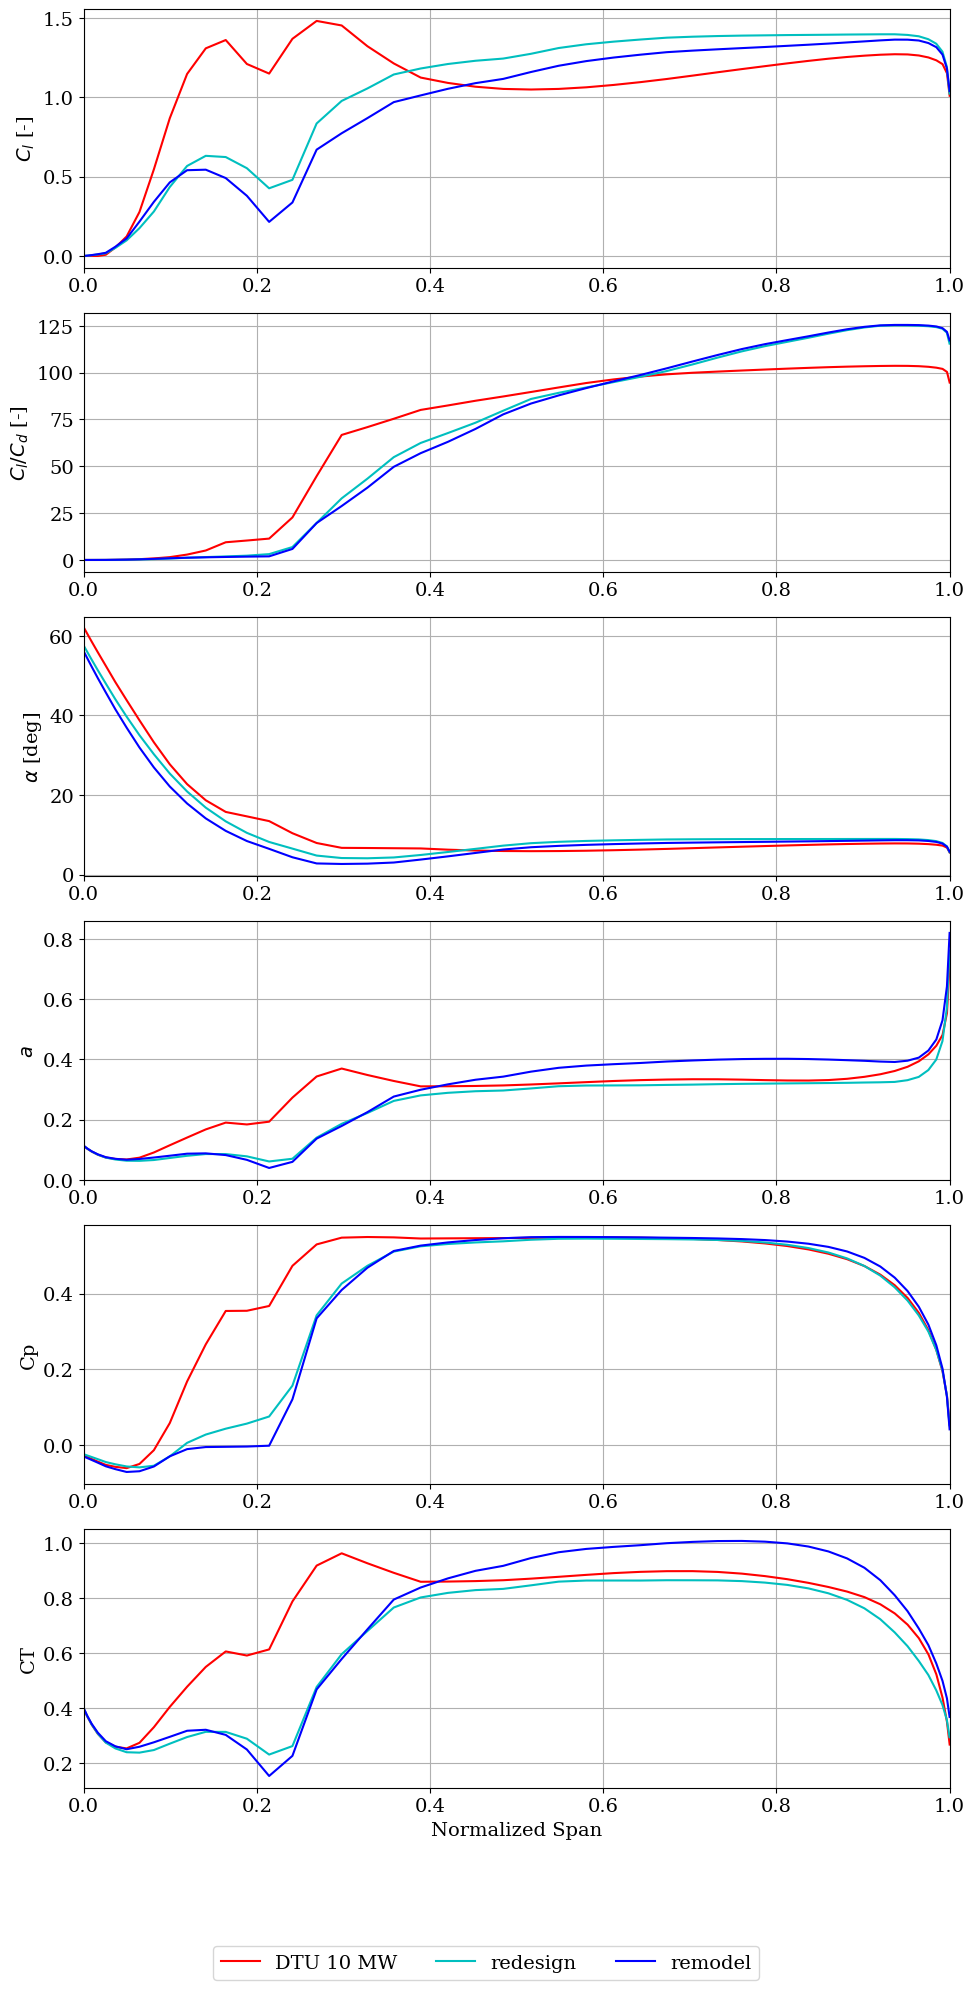

In [150]:
# open induction files

ind_rem = load_ind('remodel/res_hawc2s/remodel_hawc2s_1wsp_u11198.ind')
ind_DTU = load_ind('dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_1wsp_u8000.ind')
ind_our = load_ind('our_design/res_hawc2s/Group1_redesign_hawc2s_1wsp_u11123.ind')
R_Y_old = 92.52423873190985

x = ind_DTU["s_m"]/(R_X-r_hub)

x_i = np.argmax(x > 0.4)
x_f = np.argmax(x > 0.9)

print('mean a in central part for DTU = ', np.mean(ind_DTU["a"][x_i:x_f]))
print('mean a in central part for our = ', np.mean(ind_our["a"][x_i:x_f]))
print('mean a in central part for rem = ', np.mean(ind_rem["a"][x_i:x_f]))

# Create subplots with increased vertical spacing
fig1, axs1 = plt.subplots(6, 1, num=1, clear=True, figsize=(10, 20))  # Adjust figure size for better spacing
fig1.subplots_adjust(hspace=0.4)  # Increase the space between the plots

# Plot Cl
axs1[0].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["Cl"], color='r', label='DTU 10 MW')
axs1[0].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["Cl"], color='c', label='redesign')
axs1[0].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["Cl"], color='b', label='remodel')
axs1[0].set_ylabel("$C_l$ [-]")
axs1[0].set_xlim(0, 1)
axs1[0].grid(True)  # Add grid

# Plot Cl / Cd
axs1[1].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["Cl"]/ind_DTU["Cd"], color='r')
axs1[1].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["Cl"]/ind_our["Cd"], color='c')
axs1[1].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["Cl"]/ind_rem["Cd"], color='b')
axs1[1].set_ylabel("$C_l / C_d$ [-]")
axs1[1].set_xlim(0, 1)
axs1[1].grid(True)  # Add grid

# Plot AoA with label
axs1[2].plot(ind_DTU["s_m"]/(R_X-r_hub),     np.rad2deg(ind_DTU["aoa_rad"]), color='r')
axs1[2].plot(ind_our["s_m"]/(R_Y_old-r_hub), np.rad2deg(ind_our["aoa_rad"]), color='c')
axs1[2].plot(ind_rem["s_m"]/(R_Y-r_hub),     np.rad2deg(ind_rem["aoa_rad"]), color='b')
axs1[2].set_ylabel(r"$\alpha$ [deg]")
axs1[2].set_xlim(0, 1)
axs1[2].grid(True)  # Add grid


axs1[3].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["a"], color='r')
axs1[3].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["a"], color='c')
axs1[3].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["a"], color='b')
axs1[3].set_ylabel(r"$a$")
axs1[3].set_xlim(0, 1)
axs1[3].grid(True)  # Add grid

axs1[4].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["CP"], color='r')
axs1[4].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["CP"], color='c')
axs1[4].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["CP"], color='b')
axs1[4].set_ylabel('Cp')
axs1[4].set_xlim(0, 1)
axs1[4].grid(True)  # Add grid

axs1[5].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["CT"], color='r')
axs1[5].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["CT"], color='c')
axs1[5].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["CT"], color='b')
axs1[5].set_ylabel('CT')
axs1[5].set_xlabel("Normalized Span")  # Add label for the last plot
axs1[5].set_xlim(0, 1)
axs1[5].grid(True)  # Add grid

fig1.tight_layout()
fig1.subplots_adjust(bottom=0.1)  # Add more space at the bottom if needed
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.001))
plt.savefig('plots/bd_parameter_over_span.pdf', format='pdf')
plt.show()


In [133]:
# other comparisons from single wind speed

'''
# parameters over tc and over span

ind_rem = load_ind('remodel/res_hawc2s/remodel_hawc2s_1wsp_u11198.ind')
ind_DTU = load_ind('dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_1wsp_u8000.ind')
ind_our = load_ind('our_design/res_hawc2s/Group1_redesign_hawc2s_1wsp_u11123.ind')

r = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(design_number)
chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R_Y, cl_des, cd_des, aoa_des, chord_root, chord_max, B)
r_analytical = r - r_hub

tc_interp_rem = np.interp(ind_rem['s_m'], r_analytical, tc)
tc_interp_DTU = np.interp(ind_DTU['s_m'], r_analytical, tc)
tc_interp_our = np.interp(ind_our['s_m'], r_analytical, tc)


fig2, axs2 = plt.subplots(4, 1, num=1, figsize=(10,9), clear=True) 
axs2[0].plot(tc, cl, color='k', label='single_point_design')
axs2[0].plot(tc_interp_our[:-6], ind_our['Cl'][:-6], color='r', label='redesign')
axs2[0].plot(tc_interp_DTU[:-6], ind_DTU['Cl'][:-6], color='c', label='DTU')
axs2[0].plot(tc_interp_rem[:-6], ind_rem['Cl'][:-6], color='b', label='remodel')
axs2[0].set_ylabel("$C_l$ [-]")
axs2[0].grid(True) 

axs2[1].plot(tc, cd, color='k')
axs2[1].plot(tc_interp_our[:-6], ind_our['Cd'][:-6], color='r')
axs2[1].plot(tc_interp_DTU[:-6], ind_DTU['Cd'][:-6], color='c')
axs2[1].plot(tc_interp_rem[:-6], ind_rem['Cd'][:-6], color='b')
axs2[1].set_ylabel("$C_d$ [-]")
axs2[1].grid(True) 

axs2[2].plot(tc, cl/cd, color='k')
axs2[2].plot(tc_interp_our[:-6], ind_our['Cl'][:-6]/ind_our['Cd'][:-6], color='r')
axs2[2].plot(tc_interp_DTU[:-6], ind_DTU['Cl'][:-6]/ind_DTU['Cd'][:-6], color='c')
axs2[2].plot(tc_interp_rem[:-6], ind_rem['Cl'][:-6]/ind_rem['Cd'][:-6], color='b')
axs2[2].set_ylabel("$C_l/C_d$ [-]")
axs2[2].grid(True) 


axs2[3].plot(tc, aoa, color='k')
axs2[3].plot(tc_interp_our[:-6], np.rad2deg(ind_our['aoa_rad'][:-6]), color='r')
axs2[3].plot(tc_interp_DTU[:-6], np.rad2deg(ind_DTU['aoa_rad'][:-6]), color='c')
axs2[3].plot(tc_interp_rem[:-6], np.rad2deg(ind_rem['aoa_rad'][:-6]), color='b')
axs2[3].set_ylabel("$aoa [deg]$ [-]")
axs2[3].grid(True) 
axs2[3].set_xlabel("relative thickness")

fig2.legend(loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.05))
fig2.tight_layout()
#fig2.savefig('plots/bd_function_tc.pdf', format='pdf')
plt.show()



# open induction files

ind_rem = load_ind('remodel/res_hawc2s/remodel_hawc2s_1wsp_u11198.ind')
ind_DTU = load_ind('dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_1wsp_u8000.ind')
ind_our = load_ind('our_design/res_hawc2s/Group1_redesign_hawc2s_1wsp_u11123.ind')
R_Y_old = 92.52423873190985

# Create subplots with increased vertical spacing
fig3, axs3 = plt.subplots(6, 1, num=1, clear=True, figsize=(8, 15))  # Adjust figure size for better spacing
fig3.subplots_adjust(hspace=0.4)  # Increase the space between the plots

# Plot Cl
axs3[0].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["Cl"], color='r', label='DTU 10 MW')
axs3[0].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["Cl"], color='c', label='redesign')
axs3[0].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["Cl"], color='b', label='remodel')
axs3[0].set_ylabel("$C_l$ [-]")
axs3[0].set_xlim(0, 1)
axs3[0].grid(True)  # Add grid

# Plot Cl / Cd
axs3[1].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["Cl"]/ind_DTU["Cd"], color='r')
axs3[1].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["Cl"]/ind_our["Cd"], color='c')
axs3[1].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["Cl"]/ind_rem["Cd"], color='b')
axs3[1].set_ylabel("$C_l / C_d$ [-]")
axs3[1].set_xlim(0, 1)
axs3[1].grid(True)  # Add grid

# Plot AoA with label
axs3[2].plot(ind_DTU["s_m"]/(R_X-r_hub),     np.rad2deg(ind_DTU["aoa_rad"]), color='r')
axs3[2].plot(ind_our["s_m"]/(R_Y_old-r_hub), np.rad2deg(ind_our["aoa_rad"]), color='c')
axs3[2].plot(ind_rem["s_m"]/(R_Y-r_hub),     np.rad2deg(ind_rem["aoa_rad"]), color='b')
axs3[2].set_ylabel(r"$\alpha$ [deg]")
axs3[2].set_xlim(0, 1)
axs3[2].grid(True)  # Add grid


axs3[3].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["a"], color='r')
axs3[3].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["a"], color='c')
axs3[3].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["a"], color='b')
axs3[3].set_ylabel(r"$a$")
axs3[3].set_xlim(0, 1)
axs3[3].grid(True)  # Add grid

axs3[4].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["CP"], color='r')
axs3[4].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["CP"], color='c')
axs3[4].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["CP"], color='b')
axs3[4].set_ylabel('Cp')
axs3[4].set_xlim(0, 1)
axs3[4].grid(True)  # Add grid

axs3[5].plot(ind_DTU["s_m"]/(R_X-r_hub),     ind_DTU["CT"], color='r')
axs3[5].plot(ind_our["s_m"]/(R_Y_old-r_hub), ind_our["CT"], color='c')
axs3[5].plot(ind_rem["s_m"]/(R_Y-r_hub),     ind_rem["CT"], color='b')
axs3[5].set_ylabel('CT')
axs3[5].set_xlabel("Normalized Span")  # Add label for the last plot
axs3[5].set_xlim(0, 1)
axs3[5].grid(True)  # Add grid

fig3.tight_layout()
fig3.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.001))
fig3.subplots_adjust(bottom=0.08)  # Add more space at the bottom if needed
#fig3.savefig('03_part2_quantities_vs_radius.pdf', format='pdf')

plt.show()

'''



'\n# parameters over tc and over span\n\nind_rem = load_ind(\'remodel/res_hawc2s/remodel_hawc2s_1wsp_u11198.ind\')\nind_DTU = load_ind(\'dtu_10mw/res_hawc2s/dtu_10mw_hawc2s_1wsp_u8000.ind\')\nind_our = load_ind(\'our_design/res_hawc2s/Group1_redesign_hawc2s_1wsp_u11123.ind\')\n\nr = np.linspace(r_hub, R_Y - 0.1, 40)  # Rotor span [m]\ncl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(design_number)\nchord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(\n    r, t, tsr, R_Y, cl_des, cd_des, aoa_des, chord_root, chord_max, B)\nr_analytical = r - r_hub\n\ntc_interp_rem = np.interp(ind_rem[\'s_m\'], r_analytical, tc)\ntc_interp_DTU = np.interp(ind_DTU[\'s_m\'], r_analytical, tc)\ntc_interp_our = np.interp(ind_our[\'s_m\'], r_analytical, tc)\n\n\nfig2, axs2 = plt.subplots(4, 1, num=1, figsize=(10,9), clear=True) \naxs2[0].plot(tc, cl, color=\'k\', label=\'single_point_design\')\naxs2[0].plot(tc_interp_our[:-6], ind_our[\'Cl\'][:-6], color

## RIGID BLADE

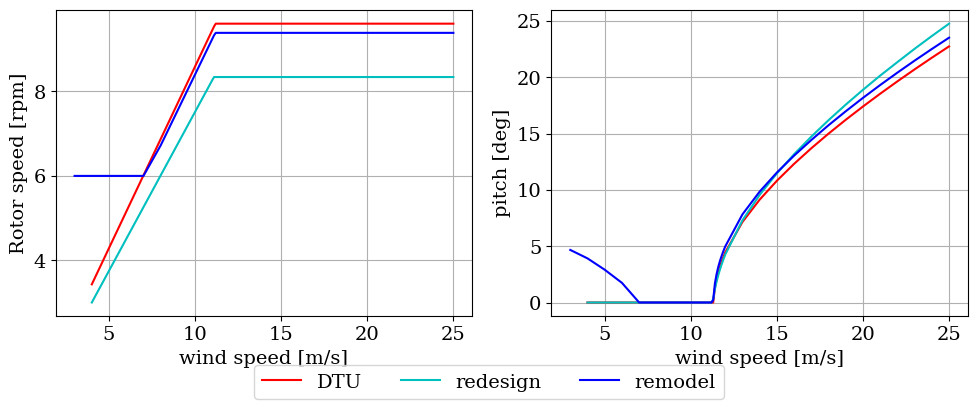

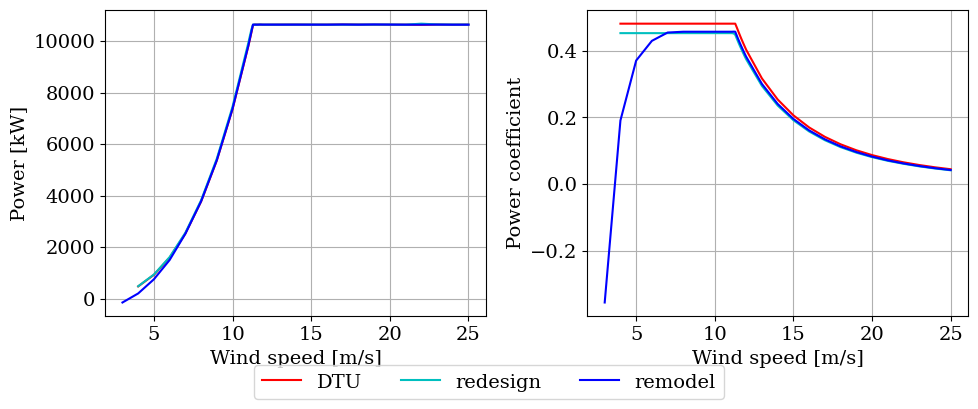

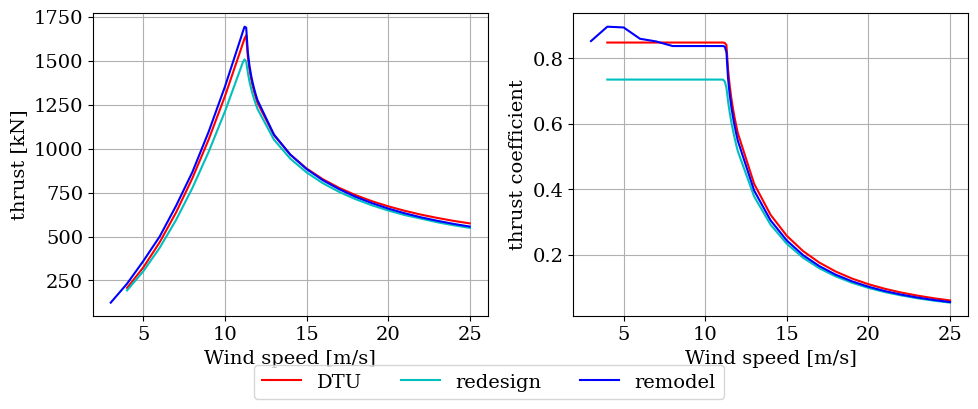

In [134]:
# operational data rigid

rigid_rem = load_oper('remodel/data/remodel_rigid.opt')
rigid_DTU = load_oper('dtu_10mw/data/dtu_10mw_rigid.opt')
rigid_our = load_oper('our_design/data/Group1_redesign_rigid.opt')

# power improvement
#imp = (rigid_data['power_kw'] - rigid_DTU_10_data['power_kw']) / rigid_DTU_10_data['power_kw']*100
#print(imp)


# plot rotor speed and pitch
fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,4), clear=True)

axs1[0].plot(rigid_DTU['ws_ms'], rigid_DTU['rotor_speed_rpm'], color='r', label='DTU')
axs1[0].plot(rigid_our['ws_ms'], rigid_our['rotor_speed_rpm'], color='c', label='redesign')
axs1[0].plot(rigid_rem['ws_ms'], rigid_rem['rotor_speed_rpm'], color='b', label='remodel')
axs1[0].set_xlabel("wind speed [m/s]")
axs1[0].set_ylabel("Rotor speed [rpm]")
axs1[0].grid(True)

axs1[1].plot(rigid_DTU['ws_ms'], rigid_DTU['pitch_deg'], color='r')
axs1[1].plot(rigid_our['ws_ms'], rigid_our['pitch_deg'], color='c')
axs1[1].plot(rigid_rem['ws_ms'], rigid_rem['pitch_deg'], color='b')
axs1[1].set_xlabel("wind speed [m/s]")
axs1[1].set_ylabel("pitch [deg]")
axs1[1].grid(True)

plt.tight_layout()
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
#plt.savefig('03_part4_rotor_pitch.pdf', format='pdf')
plt.show()


# Side-by-side plots of the aerodynamic power (left plot) and its coefficient (right plot), and the thrust (left plot) and its coefficient (right plot) versus wind speed
CP_DTU = rigid_DTU['power_kw'] / (0.5 * RHO * rigid_DTU['ws_ms']**3 * np.pi*R_X**2)*1e3
CP_our = rigid_our['power_kw'] / (0.5 * RHO * rigid_our['ws_ms']**3 * np.pi*R_Y_old**2)*1e3
CP_rem = rigid_rem['power_kw'] / (0.5 * RHO * rigid_rem['ws_ms']**3 * np.pi*R_Y**2)*1e3


CT_DTU = rigid_DTU['thrust_kn'] / (0.5 * RHO * rigid_DTU['ws_ms']**2 * np.pi*R_X**2)*1e3
CT_our = rigid_our['thrust_kn'] / (0.5 * RHO * rigid_our['ws_ms']**2 * np.pi*R_Y_old**2)*1e3
CT_rem = rigid_rem['thrust_kn'] / (0.5 * RHO * rigid_rem['ws_ms']**2 * np.pi*R_Y**2)*1e3

# power
fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,4), clear=True)
axs1[0].plot(rigid_DTU['ws_ms'], rigid_DTU['power_kw'], color='r', label='DTU')
axs1[0].plot(rigid_our['ws_ms'], rigid_our['power_kw'], color='c', label='redesign')
axs1[0].plot(rigid_rem['ws_ms'], rigid_rem['power_kw'], color='b', label='remodel')
axs1[0].set_ylabel("Power [kW]")
axs1[0].set_xlabel("Wind speed [m/s]")
axs1[0].grid(True)

axs1[1].plot(rigid_DTU['ws_ms'], CP_DTU, color='r')
axs1[1].plot(rigid_our['ws_ms'], CP_our, color='c')
axs1[1].plot(rigid_rem['ws_ms'], CP_rem, color='b')
axs1[1].set_ylabel("Power coefficient")
axs1[1].set_xlabel("Wind speed [m/s]")
axs1[1].grid(True)
plt.tight_layout()
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
#plt.savefig('03_part5_power.pdf', format='pdf')
plt.show()



# thrust
fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,4), clear=True)
axs1[0].plot(rigid_DTU['ws_ms'], rigid_DTU['thrust_kn'], color='r', label='DTU')
axs1[0].plot(rigid_our['ws_ms'], rigid_our['thrust_kn'], color='c', label='redesign')
axs1[0].plot(rigid_rem['ws_ms'], rigid_rem['thrust_kn'], color='b', label='remodel')
axs1[0].set_ylabel("thrust [kN]")
axs1[0].set_xlabel("Wind speed [m/s]")
axs1[0].grid(True)

axs1[1].plot(rigid_DTU['ws_ms'], CT_DTU, color='r')
axs1[1].plot(rigid_our['ws_ms'], CT_our, color='c')
axs1[1].plot(rigid_rem['ws_ms'], CT_rem, color='b')
axs1[1].set_ylabel("thrust coefficient")
axs1[1].set_xlabel("Wind speed [m/s]")
axs1[1].grid(True)
plt.tight_layout()
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
#plt.savefig('03_part5_power.pdf', format='pdf')
plt.show()

#plt.figure()
#plt.title('improvement')
#plt.plot(rigid_data['ws_ms'], imp)
#plt.ylabel("improvement in Power %]")
#plt.xlabel("Wind speed [m/s]")
#plt.grid(True)
#plt.show()
#

## PICK SHAVING rigid

11
9.382599
output at remodel/data/remodel_rigid_shaved.opt


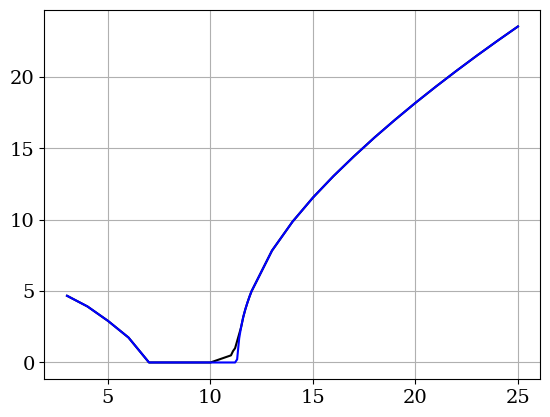

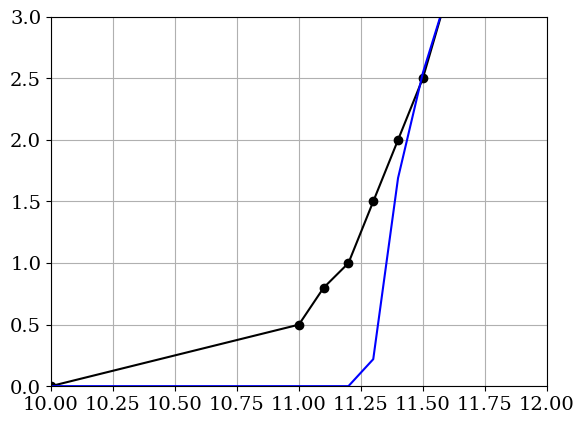

In [135]:
rigid_rem = load_oper('remodel/data/remodel_rigid.opt')

omega_last = rigid_rem['rotor_speed_rpm'][-1]
idx = np.argmin(rigid_rem['rotor_speed_rpm'] < omega_last)
print(idx+1)
print(rigid_rem['rotor_speed_rpm'][idx])


pitch = rigid_rem['pitch_deg'].copy()
pitch[idx-2] = 0.5
pitch[idx-1] = 0.8
pitch[idx]   = 1 
pitch[idx+1] = 1.5 
pitch[idx+2] = 2   
pitch[idx+3] = 2.5 


output_file = 'remodel/data/remodel_rigid_shaved.opt'

# Open the file for writing
num = len(rigid_rem['ws_ms'])
with open(output_file, 'w') as file:
    file.write(f'{num} wind speed [m/s]      pitch [deg]     rot. speed [rpm]      aero power [kw]     aero thrust [kn]\n')
    for i in range(num):
        # Construct the formatted string
        line = f"          {rigid_rem['ws_ms'][i]:6.6f}          {pitch[i]:6.6f}          {rigid_rem['rotor_speed_rpm'][i]:6.6f}          {rigid_rem['power_kw'][i]:6.6f}          {rigid_rem['thrust_kn'][i]:6.6f}\n"
        # Write the line to the file
        file.write(line)
print('output at', output_file)



plt.figure()

plt.plot(rigid_rem['ws_ms'], pitch, color='k')
plt.plot(rigid_rem['ws_ms'], rigid_rem['pitch_deg'], color='b')
plt.grid()
plt.show()

zoom = True
if zoom:
    plt.figure()
    
    plt.plot(rigid_rem['ws_ms'], pitch, color='k', marker='o')
    plt.plot(rigid_rem['ws_ms'], rigid_rem['pitch_deg'], color='b')
    plt.xlim(10,12)
    plt.ylim(0,3)
    plt.grid()
    plt.show()


output at remodel/data/remodel_rigid2.opt


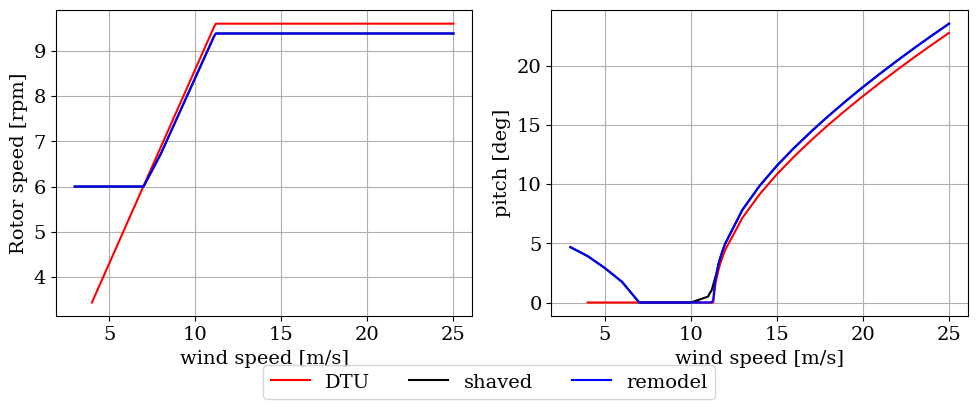

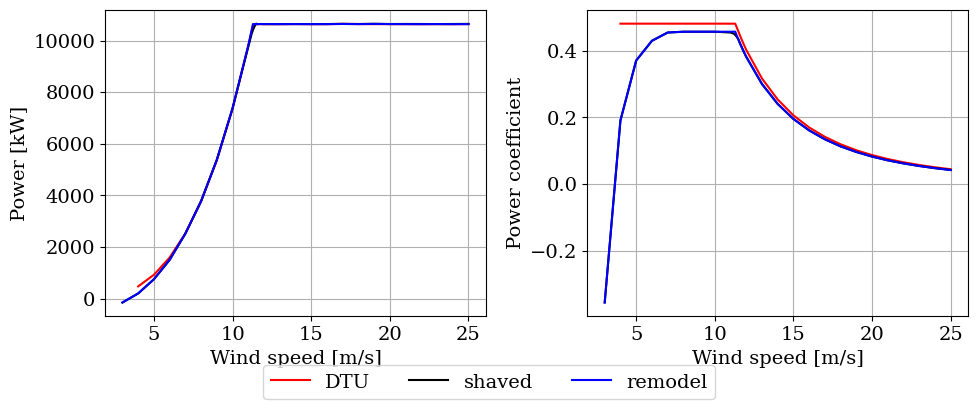

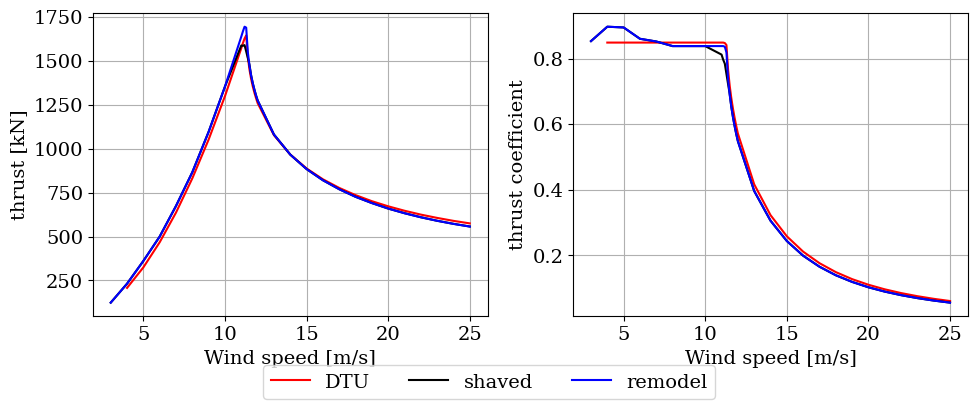

In [136]:
# result

power_rem_shave = load_pwr("remodel/res_hawc2s/remodel_hawc2s_compute_rigid_shaved.pwr")

output_file = 'remodel/data/remodel_rigid2.opt'
# Open the file for writing
num = len(power_rem_shave['V_ms'])
with open(output_file, 'w') as file:
    file.write(f'{num} wind speed [m/s]      pitch [deg]     rot. speed [rpm]      aero power [kw]     aero thrust [kn]\n')
    for i in range(num):
        # Construct the formatted string
        line = f"          {power_rem_shave['V_ms'][i]:5.6f}          {power_rem_shave['Pitch_deg'][i]:6.6f}          {power_rem_shave['Speed_rpm'][i]:6.6f}          {power_rem_shave['P_kW'][i]:6.6f}          {power_rem_shave['T_kN'][i]:6.6f}\n"
        # Write the line to the file
        file.write(line)
print('output at', output_file)



# operational data rigid

rigid_rem = load_oper('remodel/data/remodel_rigid.opt')
rigid_DTU = load_oper('dtu_10mw/data/dtu_10mw_rigid.opt')
rigid_re2 = load_oper('remodel/data/remodel_rigid2.opt')

# plot rotor speed and pitch
fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,4), clear=True)

axs1[0].plot(rigid_DTU['ws_ms'], rigid_DTU['rotor_speed_rpm'], color='r', label='DTU')
axs1[0].plot(rigid_re2['ws_ms'], rigid_re2['rotor_speed_rpm'], color='k', label='shaved')
axs1[0].plot(rigid_rem['ws_ms'], rigid_rem['rotor_speed_rpm'], color='b', label='remodel')
axs1[0].set_xlabel("wind speed [m/s]")
axs1[0].set_ylabel("Rotor speed [rpm]")
axs1[0].grid(True)

axs1[1].plot(rigid_DTU['ws_ms'], rigid_DTU['pitch_deg'], color='r')
axs1[1].plot(rigid_re2['ws_ms'], rigid_re2['pitch_deg'], color='k')
axs1[1].plot(rigid_rem['ws_ms'], rigid_rem['pitch_deg'], color='b')
axs1[1].set_xlabel("wind speed [m/s]")
axs1[1].set_ylabel("pitch [deg]")
axs1[1].grid(True)

plt.tight_layout()
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
#plt.savefig('plots/rotor_pitch.pdf', format='pdf')
plt.show()


# Side-by-side plots of the aerodynamic power (left plot) and its coefficient (right plot), and the thrust (left plot) and its coefficient (right plot) versus wind speed
CP_DTU = rigid_DTU['power_kw'] / (0.5 * RHO * rigid_DTU['ws_ms']**3 * np.pi*R_X**2)*1e3
CP_re2 = rigid_re2['power_kw'] / (0.5 * RHO * rigid_re2['ws_ms']**3 * np.pi*R_Y**2)*1e3
CP_rem = rigid_rem['power_kw'] / (0.5 * RHO * rigid_rem['ws_ms']**3 * np.pi*R_Y**2)*1e3


CT_DTU = rigid_DTU['thrust_kn'] / (0.5 * RHO * rigid_DTU['ws_ms']**2 * np.pi*R_X**2)*1e3
CT_re2 = rigid_re2['thrust_kn'] / (0.5 * RHO * rigid_re2['ws_ms']**2 * np.pi*R_Y**2)*1e3
CT_rem = rigid_rem['thrust_kn'] / (0.5 * RHO * rigid_rem['ws_ms']**2 * np.pi*R_Y**2)*1e3

# power
fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,4), clear=True)
axs1[0].plot(rigid_DTU['ws_ms'], rigid_DTU['power_kw'], color='r', label='DTU')
axs1[0].plot(rigid_re2['ws_ms'], rigid_re2['power_kw'], color='k', label='shaved')
axs1[0].plot(rigid_rem['ws_ms'], rigid_rem['power_kw'], color='b', label='remodel')
axs1[0].set_ylabel("Power [kW]")
axs1[0].set_xlabel("Wind speed [m/s]")
axs1[0].grid(True)

axs1[1].plot(rigid_DTU['ws_ms'], CP_DTU, color='r')
axs1[1].plot(rigid_re2['ws_ms'], CP_re2, color='k')
axs1[1].plot(rigid_rem['ws_ms'], CP_rem, color='b')
axs1[1].set_ylabel("Power coefficient")
axs1[1].set_xlabel("Wind speed [m/s]")
axs1[1].grid(True)
plt.tight_layout()
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
#plt.savefig('plots/bd_power.pdf', format='pdf')
plt.show()



# thrust
fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,4), clear=True)
axs1[0].plot(rigid_DTU['ws_ms'], rigid_DTU['thrust_kn'], color='r', label='DTU')
axs1[0].plot(rigid_re2['ws_ms'], rigid_re2['thrust_kn'], color='k', label='shaved')
axs1[0].plot(rigid_rem['ws_ms'], rigid_rem['thrust_kn'], color='b', label='remodel')
axs1[0].set_ylabel("thrust [kN]")
axs1[0].set_xlabel("Wind speed [m/s]")
axs1[0].grid(True)

axs1[1].plot(rigid_DTU['ws_ms'], CT_DTU, color='r')
axs1[1].plot(rigid_re2['ws_ms'], CT_re2, color='k')
axs1[1].plot(rigid_rem['ws_ms'], CT_rem, color='b')
axs1[1].set_ylabel("thrust coefficient")
axs1[1].set_xlabel("Wind speed [m/s]")
axs1[1].grid(True)
plt.tight_layout()
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
#plt.savefig('plots/bd_thrust.pdf', format='pdf')
plt.show()



## FLEX BLADE

In [137]:
# create new remodel_RWT_Blade file

st_data_DTU10MW = load_st('remodel/data/DTU_10MW_RWT_Blade_st.dat', 0, 0)  # Baseline data

# Scaling factor
R_old = R_X
R_new = R_Y 
scale_factor = R_new / R_old
print('scale factors:', scale_factor, scale_factor**2,scale_factor**3,scale_factor**4)

st_data = scale_ST_data(st_data_DTU10MW, scale_factor)

st_data_rigid = st_data.copy()
st_data_rigid["E"] = st_data["E"]*1e7
st_data_rigid["G"] = st_data["G"]*1e9

# Saving the upscaled data
path_out = 'remodel/data/remodel_RWT_Blade_st.dat'
save_st(path_out, [st_data, st_data_rigid])


scale factors: 1.0272400621800015 1.0552221453475734 1.0839664622005558 1.1134937760319352


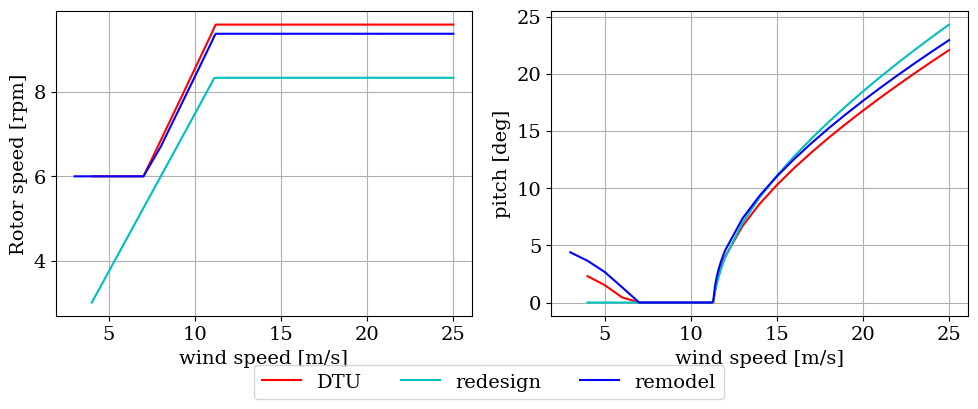

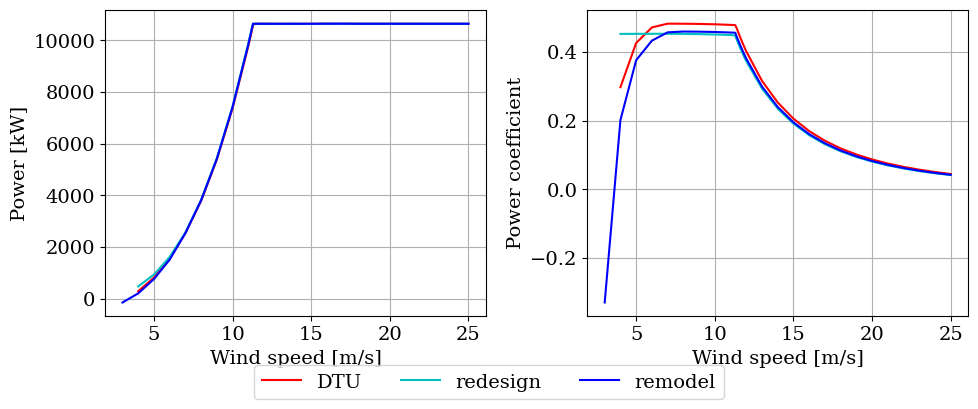

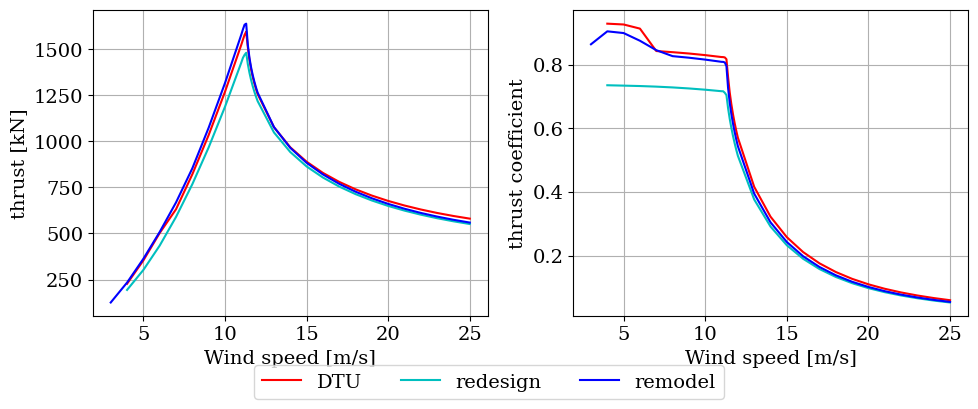

In [138]:
# operational data flex

flex_rem = load_oper('remodel/data/remodel_flex.opt')
flex_DTU = load_oper('dtu_10mw/data/dtu_10mw_flex_minrotspd.opt')
flex_our = load_oper('our_design/data/Group1_redesign_flex.opt')


# plot rotor speed and pitch
fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,4), clear=True)

axs1[0].plot(flex_DTU['ws_ms'], flex_DTU['rotor_speed_rpm'], color='r', label='DTU')
axs1[0].plot(flex_our['ws_ms'], flex_our['rotor_speed_rpm'], color='c', label='redesign')
axs1[0].plot(flex_rem['ws_ms'], flex_rem['rotor_speed_rpm'], color='b', label='remodel')
axs1[0].set_xlabel("wind speed [m/s]")
axs1[0].set_ylabel("Rotor speed [rpm]")
axs1[0].grid(True)

axs1[1].plot(flex_DTU['ws_ms'], flex_DTU['pitch_deg'], color='r')
axs1[1].plot(flex_our['ws_ms'], flex_our['pitch_deg'], color='c')
axs1[1].plot(flex_rem['ws_ms'], flex_rem['pitch_deg'], color='b')
axs1[1].set_xlabel("wind speed [m/s]")
axs1[1].set_ylabel("pitch [deg]")
axs1[1].grid(True)

plt.tight_layout()
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
#plt.savefig('03_part4_rotor_pitch.pdf', format='pdf')
plt.show()


# Side-by-side plots of the aerodynamic power (left plot) and its coefficient (right plot), and the thrust (left plot) and its coefficient (right plot) versus wind speed
CP_DTU = flex_DTU['power_kw'] / (0.5 * RHO * flex_DTU['ws_ms']**3 * np.pi*R_X**2)*1e3
CP_our = flex_our['power_kw'] / (0.5 * RHO * flex_our['ws_ms']**3 * np.pi*R_Y_old**2)*1e3
CP_rem = flex_rem['power_kw'] / (0.5 * RHO * flex_rem['ws_ms']**3 * np.pi*R_Y**2)*1e3


CT_DTU = flex_DTU['thrust_kn'] / (0.5 * RHO * flex_DTU['ws_ms']**2 * np.pi*R_X**2)*1e3
CT_our = flex_our['thrust_kn'] / (0.5 * RHO * flex_our['ws_ms']**2 * np.pi*R_Y_old**2)*1e3
CT_rem = flex_rem['thrust_kn'] / (0.5 * RHO * flex_rem['ws_ms']**2 * np.pi*R_Y**2)*1e3

# power
fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,4), clear=True)
axs1[0].plot(flex_DTU['ws_ms'], flex_DTU['power_kw'], color='r', label='DTU')
axs1[0].plot(flex_our['ws_ms'], flex_our['power_kw'], color='c', label='redesign')
axs1[0].plot(flex_rem['ws_ms'], flex_rem['power_kw'], color='b', label='remodel')
axs1[0].set_ylabel("Power [kW]")
axs1[0].set_xlabel("Wind speed [m/s]")
axs1[0].grid(True)

axs1[1].plot(flex_DTU['ws_ms'], CP_DTU, color='r')
axs1[1].plot(flex_our['ws_ms'], CP_our, color='c')
axs1[1].plot(flex_rem['ws_ms'], CP_rem, color='b')
axs1[1].set_ylabel("Power coefficient")
axs1[1].set_xlabel("Wind speed [m/s]")
axs1[1].grid(True)
plt.tight_layout()
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
#plt.savefig('03_part5_power.pdf', format='pdf')
plt.show()



# thrust
fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,4), clear=True)
axs1[0].plot(flex_DTU['ws_ms'], flex_DTU['thrust_kn'], color='r', label='DTU')
axs1[0].plot(flex_our['ws_ms'], flex_our['thrust_kn'], color='c', label='redesign')
axs1[0].plot(flex_rem['ws_ms'], flex_rem['thrust_kn'], color='b', label='remodel')
axs1[0].set_ylabel("thrust [kN]")
axs1[0].set_xlabel("Wind speed [m/s]")
axs1[0].grid(True)

axs1[1].plot(flex_DTU['ws_ms'], CT_DTU, color='r')
axs1[1].plot(flex_our['ws_ms'], CT_our, color='c')
axs1[1].plot(flex_rem['ws_ms'], CT_rem, color='b')
axs1[1].set_ylabel("thrust coefficient")
axs1[1].set_xlabel("Wind speed [m/s]")
axs1[1].grid(True)
plt.tight_layout()
fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
#plt.savefig('03_part5_power.pdf', format='pdf')
plt.show()

#plt.figure()
#plt.title('improvement')
#plt.plot(flex_data['ws_ms'], imp)
#plt.ylabel("improvement in Power %]")
#plt.xlabel("Wind speed [m/s]")
#plt.grid(True)
#plt.show()
#

## PEACK SHAVING flex

11
9.382599
output at remodel/data/remodel_flex_shaved.opt
output at remodel/data/remodel_flex_shaved2.opt


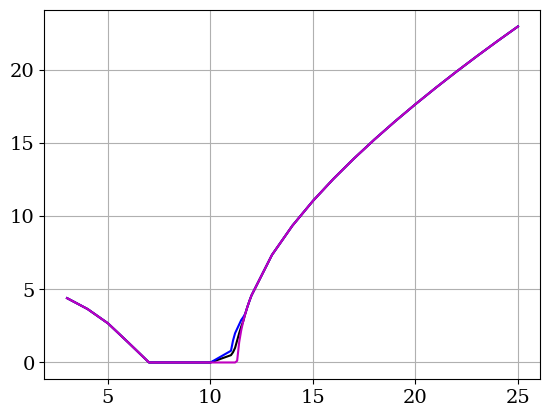

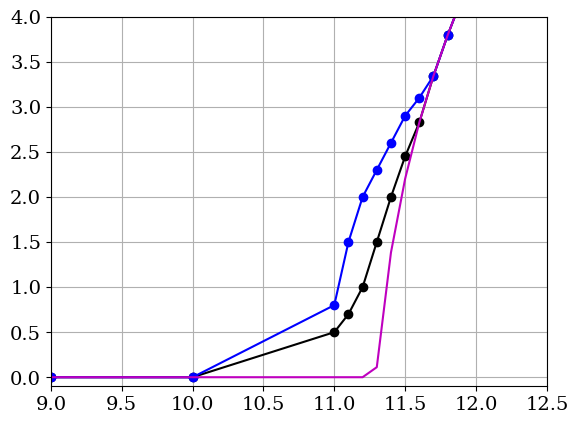

In [139]:
flex_rem = load_oper('remodel/data/remodel_flex.opt')

omega_last = flex_rem['rotor_speed_rpm'][-1]
idx = np.argmin(flex_rem['rotor_speed_rpm'] < omega_last)
print(idx+1)
print(flex_rem['rotor_speed_rpm'][idx])


pitch = flex_rem['pitch_deg'].copy()
pitch[idx-2] = 0.5
pitch[idx-1] = 0.7
pitch[idx]   = 1 
pitch[idx+1] = 1.5 
pitch[idx+2] = 2   
pitch[idx+3] = 2.45 


output_file = 'remodel/data/remodel_flex_shaved.opt'

# Open the file for writing
num = len(flex_rem['ws_ms'])
with open(output_file, 'w') as file:
    file.write(f'{num} wind speed [m/s]      pitch [deg]     rot. speed [rpm]      aero power [kw]     aero thrust [kn]\n')
    for i in range(num):
        # Construct the formatted string
        line = f"          {flex_rem['ws_ms'][i]:6.6f}          {pitch[i]:6.6f}          {flex_rem['rotor_speed_rpm'][i]:6.6f}          {flex_rem['power_kw'][i]:6.6f}          {flex_rem['thrust_kn'][i]:6.6f}\n"
        # Write the line to the file
        file.write(line)
print('output at', output_file)




# redo with more agressive pitching
pitch_new = flex_rem['pitch_deg'].copy()
pitch_new[idx-3] = 0
pitch_new[idx-2] = 0.8
pitch_new[idx-1] = 1.5
pitch_new[idx]   = 2 
pitch_new[idx+1] = 2.3 
pitch_new[idx+2] = 2.6   
pitch_new[idx+3] = 2.9 
pitch_new[idx+4] = 3.1 

output_file = 'remodel/data/remodel_flex_shaved2.opt'
# Open the file for writing
num = len(flex_rem['ws_ms'])
with open(output_file, 'w') as file:
    file.write(f'{num-1} wind speed [m/s]      pitch [deg]     rot. speed [rpm]      aero power [kw]     aero thrust [kn]\n')
    for i in range(1,num):
        # Construct the formatted string
        line = f"          {flex_rem['ws_ms'][i]:6.6f}          {pitch_new[i]:6.6f}          {flex_rem['rotor_speed_rpm'][i]:6.6f}          {flex_rem['power_kw'][i]:6.6f}          {flex_rem['thrust_kn'][i]:6.6f}\n"
        # Write the line to the file
        file.write(line)
print('output at', output_file)


plt.figure()
plt.plot(flex_rem['ws_ms'], pitch, color='k')
plt.plot(flex_rem['ws_ms'], pitch_new, color='b')
plt.plot(flex_rem['ws_ms'], flex_rem['pitch_deg'], color='m')
plt.grid()
plt.show()

zoom = True
if zoom:
    plt.figure()
    
    plt.plot(flex_rem['ws_ms'], pitch, color='k', marker='o')
    plt.plot(flex_rem['ws_ms'], pitch_new, color='b', marker='o')
    plt.plot(flex_rem['ws_ms'], flex_rem['pitch_deg'], color='m')
    plt.xlim(9,12.5)
    plt.ylim(-0.1,4)
    plt.grid()
    plt.show()


output at remodel/data/remodel_flex2.opt
output at remodel/data/remodel_flex3.opt


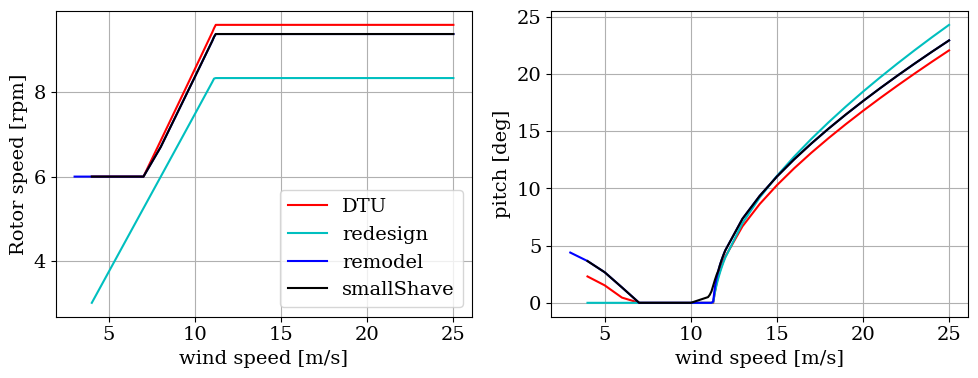

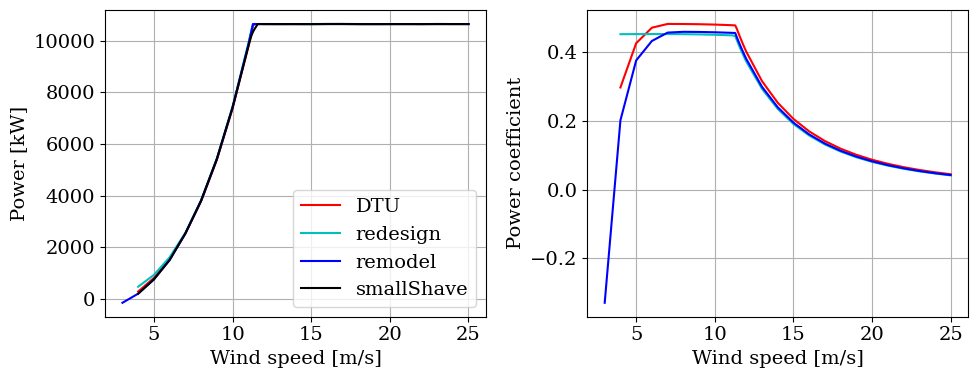

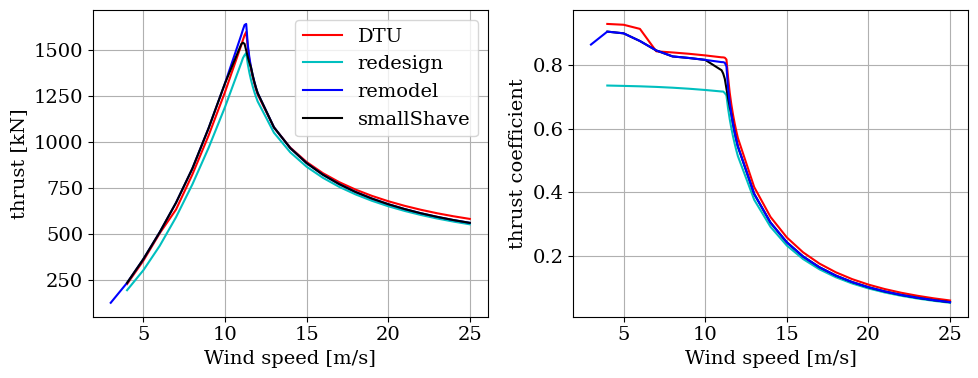

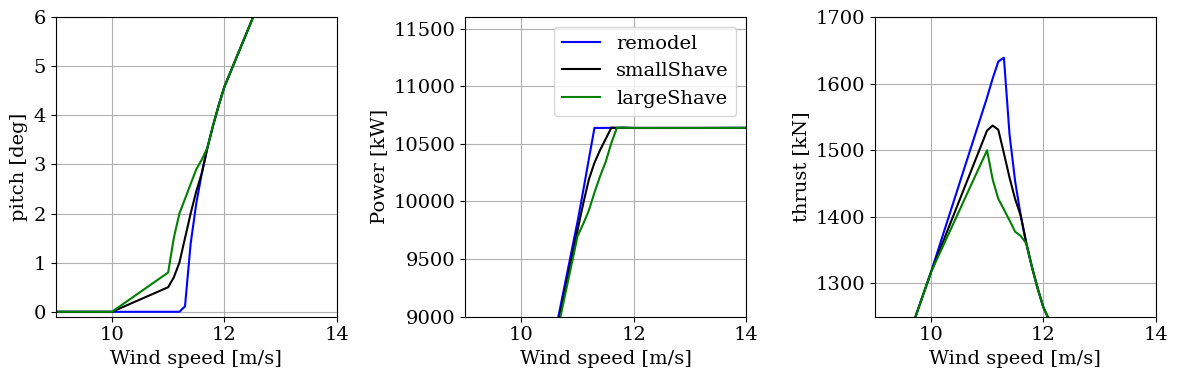

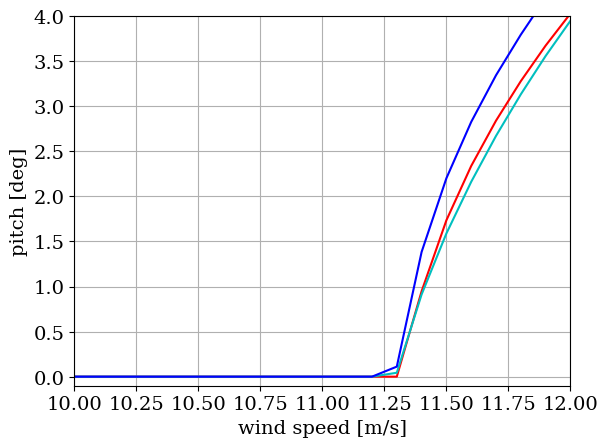

In [161]:
# result

power_rem_shave = load_pwr("remodel/res_hawc2s/remodel_hawc2s_compute_flex_shaved.pwr")

output_file = 'remodel/data/remodel_flex2.opt'
# Open the file for writing
num = len(power_rem_shave['V_ms'])
with open(output_file, 'w') as file:
    file.write(f'{num-1} wind speed [m/s]      pitch [deg]     rot. speed [rpm]      aero power [kw]     aero thrust [kn]\n')
    #for i in range(num):
    for i in range(1,num):
        # Construct the formatted string
        line = f"          {power_rem_shave['V_ms'][i]:5.6f}          {power_rem_shave['Pitch_deg'][i]:6.6f}          {power_rem_shave['Speed_rpm'][i]:6.6f}          {power_rem_shave['P_kW'][i]:6.6f}          {power_rem_shave['T_kN'][i]:6.6f}\n"
        # Write the line to the file
        file.write(line)
print('output at', output_file)



power_rem_shave = load_pwr("remodel/res_hawc2s/remodel_hawc2s_compute_flex_shaved2.pwr")
output_file = 'remodel/data/remodel_flex3.opt'
# Open the file for writing
num = len(power_rem_shave['V_ms'])
with open(output_file, 'w') as file:
    file.write(f'{num-1} wind speed [m/s]      pitch [deg]     rot. speed [rpm]      aero power [kw]     aero thrust [kn]\n')
    #for i in range(num):
    for i in range(1,num):
        # Construct the formatted string
        line = f"          {power_rem_shave['V_ms'][i]:5.6f}          {power_rem_shave['Pitch_deg'][i]:6.6f}          {power_rem_shave['Speed_rpm'][i]:6.6f}          {power_rem_shave['P_kW'][i]:6.6f}          {power_rem_shave['T_kN'][i]:6.6f}\n"
        # Write the line to the file
        file.write(line)
print('output at', output_file)



# operational data flex

flex_DTU = load_oper('dtu_10mw/data/dtu_10mw_flex_minrotspd.opt')
flex_our = load_oper('our_design/data/Group1_redesign_flex.opt')
flex_rem = load_oper('remodel/data/remodel_flex.opt')           # remodel
flex_re2 = load_oper('remodel/data/remodel_flex2.opt')          # smallShave
flex_re3 = load_oper('remodel/data/remodel_flex3.opt')          # largeShave


# plot rotor speed and pitch
fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,4), clear=True)

axs1[0].plot(flex_DTU['ws_ms'], flex_DTU['rotor_speed_rpm'], color='r', label='DTU')
axs1[0].plot(flex_our['ws_ms'], flex_our['rotor_speed_rpm'], color='c', label='redesign')
axs1[0].plot(flex_rem['ws_ms'], flex_rem['rotor_speed_rpm'], color='b', label='remodel')
axs1[0].plot(flex_re2['ws_ms'], flex_re2['rotor_speed_rpm'], color='k', label='smallShave')
axs1[0].set_xlabel("wind speed [m/s]")
axs1[0].set_ylabel("Rotor speed [rpm]")
axs1[0].grid(True)
axs1[0].legend()

axs1[1].plot(flex_DTU['ws_ms'], flex_DTU['pitch_deg'], color='r')
axs1[1].plot(flex_our['ws_ms'], flex_our['pitch_deg'], color='c')
axs1[1].plot(flex_rem['ws_ms'], flex_rem['pitch_deg'], color='b')
axs1[1].plot(flex_re2['ws_ms'], flex_re2['pitch_deg'], color='k')
axs1[1].set_xlabel("wind speed [m/s]")
axs1[1].set_ylabel("pitch [deg]")
axs1[1].grid(True)

plt.tight_layout()
#fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.savefig('plots/bd_rotor_pitch.pdf', format='pdf')
plt.show()


# Side-by-side plots of the aerodynamic power (left plot) and its coefficient (right plot), and the thrust (left plot) and its coefficient (right plot) versus wind speed
CP_DTU = flex_DTU['power_kw']  / (0.5 * RHO * flex_DTU['ws_ms']**3 * np.pi*R_X**2)*1e3
CP_our = flex_our['power_kw']  / (0.5 * RHO * flex_our['ws_ms']**3 * np.pi*R_Y_old**2)*1e3
CP_rem = flex_rem['power_kw']  / (0.5 * RHO * flex_rem['ws_ms']**3 * np.pi*R_Y**2)*1e3
CP_re2 = flex_re2['power_kw']  / (0.5 * RHO * flex_re2['ws_ms']**3 * np.pi*R_Y**2)*1e3
CP_re3 = flex_re3['power_kw']  / (0.5 * RHO * flex_re3['ws_ms']**3 * np.pi*R_Y**2)*1e3

CT_DTU = flex_DTU['thrust_kn'] / (0.5 * RHO * flex_DTU['ws_ms']**2 * np.pi*R_X**2)*1e3
CT_our = flex_our['thrust_kn'] / (0.5 * RHO * flex_our['ws_ms']**2 * np.pi*R_Y_old**2)*1e3
CT_rem = flex_rem['thrust_kn'] / (0.5 * RHO * flex_rem['ws_ms']**2 * np.pi*R_Y**2)*1e3
CT_re2 = flex_re2['thrust_kn'] / (0.5 * RHO * flex_re2['ws_ms']**2 * np.pi*R_Y**2)*1e3
CT_re3 = flex_re3['thrust_kn'] / (0.5 * RHO * flex_re3['ws_ms']**2 * np.pi*R_Y**2)*1e3


# power
fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,4), clear=True)
axs1[0].plot(flex_DTU['ws_ms'], flex_DTU['power_kw'], color='r', label='DTU')
axs1[0].plot(flex_our['ws_ms'], flex_our['power_kw'], color='c', label='redesign')
axs1[0].plot(flex_rem['ws_ms'], flex_rem['power_kw'], color='b', label='remodel')
axs1[0].plot(flex_re2['ws_ms'], flex_re2['power_kw'], color='k', label='smallShave')
axs1[0].set_ylabel("Power [kW]")
axs1[0].set_xlabel("Wind speed [m/s]")
axs1[0].grid(True)
axs1[0].legend()

axs1[1].plot(flex_DTU['ws_ms'], CP_DTU, color='r')
axs1[1].plot(flex_our['ws_ms'], CP_our, color='c')
axs1[1].plot(flex_rem['ws_ms'], CP_rem, color='b')
#axs1[1].plot(flex_re2['ws_ms'], CP_re2, color='k')
axs1[1].set_ylabel("Power coefficient")
axs1[1].set_xlabel("Wind speed [m/s]")
axs1[1].grid(True)
plt.tight_layout()
#fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.savefig('plots/bd_power.pdf', format='pdf')
plt.show()



# thrust
fig1, axs1 = plt.subplots(1, 2, num=2, figsize=(10,4), clear=True)
axs1[0].plot(flex_DTU['ws_ms'], flex_DTU['thrust_kn'], color='r', label='DTU')
axs1[0].plot(flex_our['ws_ms'], flex_our['thrust_kn'], color='c', label='redesign')
axs1[0].plot(flex_rem['ws_ms'], flex_rem['thrust_kn'], color='b', label='remodel')
axs1[0].plot(flex_re2['ws_ms'], flex_re2['thrust_kn'], color='k', label='smallShave')
axs1[0].set_ylabel("thrust [kN]")
axs1[0].set_xlabel("Wind speed [m/s]")
axs1[0].grid(True)
axs1[0].legend()

axs1[1].plot(flex_DTU['ws_ms'], CT_DTU, color='r')
axs1[1].plot(flex_our['ws_ms'], CT_our, color='c')
axs1[1].plot(flex_re2['ws_ms'], CT_re2, color='k')
axs1[1].plot(flex_rem['ws_ms'], CT_rem, color='b')
axs1[1].set_ylabel("thrust coefficient")
axs1[1].set_xlabel("Wind speed [m/s]")
axs1[1].grid(True)
plt.tight_layout()
#fig1.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.savefig('plots/bd_thrust.pdf', format='pdf')
plt.show()




# small shave and large shave
fig1, axs1 = plt.subplots(1, 3, num=3, figsize=(12,4), clear=True)
axs1[0].plot(flex_rem['ws_ms'], flex_rem['pitch_deg'], color='b')
axs1[0].plot(flex_re2['ws_ms'], flex_re2['pitch_deg'], color='k')
axs1[0].plot(flex_re3['ws_ms'], flex_re3['pitch_deg'], color='g')
axs1[0].set_ylabel("pitch [deg]")
axs1[0].set_xlabel("Wind speed [m/s]")
axs1[0].grid(True)
axs1[0].set_xlim([9,14])
axs1[0].set_ylim([-0.1,6])

axs1[1].plot(flex_rem['ws_ms'], flex_rem['power_kw'], color='b', label='remodel')
axs1[1].plot(flex_re2['ws_ms'], flex_re2['power_kw'], color='k', label='smallShave')
axs1[1].plot(flex_re3['ws_ms'], flex_re3['power_kw'], color='g', label='largeShave')
axs1[1].set_ylabel("Power [kW]")
axs1[1].set_xlabel("Wind speed [m/s]")
axs1[1].grid(True)
axs1[1].set_xlim([9,14])
axs1[1].set_ylim([9000,11600])
axs1[1].legend()

axs1[2].plot(flex_rem['ws_ms'], flex_rem['thrust_kn'], color='b')
axs1[2].plot(flex_re2['ws_ms'], flex_re2['thrust_kn'], color='k')
axs1[2].plot(flex_re3['ws_ms'], flex_re3['thrust_kn'], color='g')
axs1[2].set_ylabel("thrust [kN]")
axs1[2].set_xlabel("Wind speed [m/s]")
axs1[2].grid(True)
axs1[2].set_xlim([9,14])
axs1[2].set_ylim([1250,1700])

plt.tight_layout()
#fig1.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
plt.savefig('plots/bd_large_small_shave.pdf', format='pdf')
plt.show()



plt.figure()
plt.plot(flex_DTU['ws_ms'], flex_DTU['pitch_deg'], color='r')
plt.plot(flex_our['ws_ms'], flex_our['pitch_deg'], color='c')
plt.plot(flex_rem['ws_ms'], flex_rem['pitch_deg'], color='b')
plt.xlabel("wind speed [m/s]")
plt.ylabel("pitch [deg]")
plt.xlim(10,12)
plt.ylim(-0.1,4)
plt.grid(True)
plt.show()

